# 📊 So sánh Mô hình: RAW DATA vs PREPARED DATA

## 🎯 Mục tiêu chính
**Chứng minh giá trị của Data Preparation** bằng cách so sánh 2 pipelines hoàn toàn riêng biệt:

### **PIPELINE 1 - RAW DATA (Baseline)**
Dữ liệu thô, xử lý tối thiểu:
- ✅ Chỉ drop missing values quan trọng
- ✅ Không có cleaning đặc biệt
- ✅ Không có transformation
- ✅ Không có feature engineering
- 🎯 **Kết quả**: Baseline performance

### **PIPELINE 2 - PREPARED DATA (Full Treatment)**
Dữ liệu đã qua Data Preparation đầy đủ:
- ✅ **Cleaning**: Loại bỏ outliers, invalid data, duplicates
- ✅ **Transform**: Normalize odds, standardize dates, encode categories
- ✅ **Engineering**: Tạo rolling features, momentum, rest days, streaks
- 🎯 **Kết quả**: Enhanced performance

**So sánh**: Model performance trên 2 datasets này sẽ cho thấy **giá trị thực sự** của Data Preparation!

---

In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, classification_report, confusion_matrix
from sklearn.utils import resample
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


# PART 1: LOAD & INITIAL SETUP

In [139]:
# Load data
df_original = pd.read_csv("data/Matches.csv")
print(f"📂 Original data loaded: {df_original.shape}")

# Lọc top 5 leagues
top_leagues = ['E0', 'SP1', 'D1', 'I1', 'F1']
df_original = df_original[df_original['Division'].isin(top_leagues)]
print(f"📊 After filtering top 5 leagues: {df_original.shape}")

# Tạo 2 bản copy độc lập
df_raw = df_original.copy()
df_prepared = df_original.copy()

print("\n✅ Created 2 independent datasets:")
print(f"   - df_raw: {df_raw.shape}")
print(f"   - df_prepared: {df_prepared.shape}")

📂 Original data loaded: (230557, 48)
📊 After filtering top 5 leagues: (43708, 48)

✅ Created 2 independent datasets:
   - df_raw: (43708, 48)
   - df_prepared: (43708, 48)


---

# PIPELINE 1: RAW DATA

## 1.1 Minimal Cleaning & Initial Setup

In [140]:
print("="*80)
print("PIPELINE 1: RAW DATA - MINIMAL PROCESSING")
print("="*80)

# Chỉ xử lý những gì BẮT BUỘC để model chạy được

# 1. Convert date - FIXED: Thêm dayfirst=True để thống nhất với PREPARED pipeline
df_raw['MatchDate'] = pd.to_datetime(df_raw['MatchDate'], dayfirst=True, errors='coerce')

# 2. Drop chỉ những missing values quan trọng
df_raw = df_raw.dropna()

# 3. Create simple target
# Option 1: fixed threshold
# HOME_ADVANTAGE = 50
# ELO_THRESHOLD = 150

# df_raw['Elo_diff'] = (df_raw['HomeElo'] + HOME_ADVANTAGE - df_raw['AwayElo'])
# df_raw['underdog'] = np.where(df_raw['Elo_diff'] <= -ELO_THRESHOLD, 'Home',
#                     np.where(df_raw['Elo_diff'] >= ELO_THRESHOLD, 'Away', 'None'))
# df_raw['is_cinderella'] = (
#     ((df_raw['underdog'] == 'Home') & (df_raw['FTResult'] == 'H')) |
#     ((df_raw['underdog'] == 'Away') & (df_raw['FTResult'] == 'A'))
# ).astype(int)

# Option 2: Using probabilities
HOME_ADVANTAGE = 100
PROB_THRESHOLD = 0.3 # Underdog win probability must be less than this

# # Calculate Elo difference and probabilities
df_raw['Elo_diff'] = (df_raw['HomeElo'] + HOME_ADVANTAGE - df_raw['AwayElo'])
df_raw['Prob_HomeWin'] = 1 / (1 + 10 ** (-df_raw['Elo_diff'] / 400))
df_raw['Prob_AwayWin'] = 1 - df_raw['Prob_HomeWin']

# Determine favorite and underdog based on probability
df_raw['favorite'] = np.where(df_raw['Prob_HomeWin'] >= 0.5, 'Home', 'Away')
df_raw['underdog'] = np.where(df_raw['favorite'] == 'Home', 'Away', 'Home')

# Get the underdog's win probability
df_raw['Prob_UnderdogWin'] = np.where(df_raw['underdog'] == 'Home', df_raw['Prob_HomeWin'], df_raw['Prob_AwayWin'])

# Determine if the result is a cinderella win
underdog_wins = (
    ((df_raw['underdog'] == 'Home') & (df_raw['FTResult'] == 'H')) |
    ((df_raw['underdog'] == 'Away') & (df_raw['FTResult'] == 'A'))
)
is_low_prob = (df_raw['Prob_UnderdogWin'] < PROB_THRESHOLD)

df_raw['is_cinderella'] = (underdog_wins & is_low_prob).astype(int)

print(f"\n📊 RAW DATA after minimal processing:")
print(f"   Shape: {df_raw.shape}")
print(f"   Cinderella rate: {df_raw['is_cinderella'].mean():.2%}")
print(f"   Missing values: {df_raw.isnull().sum().sum()}")

print(df_raw['is_cinderella'].value_counts())

PIPELINE 1: RAW DATA - MINIMAL PROCESSING

📊 RAW DATA after minimal processing:
   Shape: (10686, 55)
   Cinderella rate: 6.72%
   Missing values: 0
is_cinderella
0    9968
1     718
Name: count, dtype: int64


## 1.2 Extract RAW features (chỉ dữ liệu có sẵn)

In [141]:
def extract_raw_features(df):
    """
    Extract RAW features - chỉ dữ liệu có sẵn, không tạo mới
    """
    features = []
    
    # Basic Elo
    if 'HomeElo' in df.columns:
        features.append('HomeElo')
    if 'AwayElo' in df.columns:
        features.append('AwayElo')
    # if 'Elo_diff' in df.columns:
    #     features.append('Elo_diff')
    
    # Form có sẵn (nếu có)
    
    for col in ['Form3Home', 'Form3Away', 'Form5Home', 'Form5Away']:
        if col in df.columns:
            features.append(col)
    
    print(f"\n📋 RAW features extracted: {len(features)}")
    print(f"   Features: {features}")
    
    return features

raw_feature_cols = extract_raw_features(df_raw)
print(f"\n✅ Total RAW features: {len(raw_feature_cols)}")


📋 RAW features extracted: 6
   Features: ['HomeElo', 'AwayElo', 'Form3Home', 'Form3Away', 'Form5Home', 'Form5Away']

✅ Total RAW features: 6


---

# PIPELINE 2: PREPARED DATA (FULL DATA PREPARATION)

## 2.1 STEP 1: DATA CLEANING

In [142]:
print("\n" + "="*80)
print("PIPELINE 2: PREPARED DATA - FULL DATA PREPARATION")
print("="*80)

print("\n🧹 STEP 1: DATA CLEANING")
print("-"*80)

# 1.1 Convert dates
df_prepared['MatchDate'] = pd.to_datetime(df_prepared['MatchDate'], dayfirst=True, errors='coerce')

# 1.2 Remove invalid data
print("   1. Removing invalid data...")
before = len(df_prepared)

# Negative goals
df_prepared = df_prepared[
    (df_prepared['FTHome'] >= 0) & 
    (df_prepared['FTAway'] >= 0)
]

# Invalid Elo
df_prepared = df_prepared[
    (df_prepared['HomeElo'] > 0) & 
    (df_prepared['AwayElo'] > 0)
]

print(f"      Removed {before - len(df_prepared)} invalid rows")

# 1.3 Remove duplicates
before = len(df_prepared)
df_prepared = df_prepared.drop_duplicates()
print(f"   2. Removed {before - len(df_prepared)} duplicates")

# 1.4 Handle outliers in Elo
elo_cols = ['HomeElo', 'AwayElo']
for col in elo_cols:
    q1 = df_prepared[col].quantile(0.01)
    q99 = df_prepared[col].quantile(0.99)
    df_prepared = df_prepared[
        (df_prepared[col] >= q1) & 
        (df_prepared[col] <= q99)
    ]

print(f"   3. Removed Elo outliers (1st-99th percentile)")

print(f"\n✅ After cleaning: {df_prepared.shape}")


PIPELINE 2: PREPARED DATA - FULL DATA PREPARATION

🧹 STEP 1: DATA CLEANING
--------------------------------------------------------------------------------
   1. Removing invalid data...
      Removed 40 invalid rows
   2. Removed 0 duplicates
   3. Removed Elo outliers (1st-99th percentile)

✅ After cleaning: (41938, 48)


## 2.2 STEP 2: DATA TRANSFORMATION

In [143]:
print("\n🔄 STEP 2: DATA TRANSFORMATION")
print("-"*80)

# 2.1 Normalize odds (if exist)
odds_cols = [c for c in df_prepared.columns if 'Odd' in c or 'B365' in c]
if odds_cols:
    print(f"   1. Normalizing {len(odds_cols)} odds columns...")
    for col in odds_cols:
        df_prepared[col] = pd.to_numeric(df_prepared[col], errors='coerce')
        # Replace invalid odds
        df_prepared.loc[df_prepared[col] <= 1, col] = np.nan

# 2.2 Sort by date
df_prepared = df_prepared.sort_values('MatchDate').reset_index(drop=True)
print("   2. Sorted by MatchDate")

# 2.3 Trim team names
for col in ['HomeTeam', 'AwayTeam']:
    if col in df_prepared.columns:
        df_prepared[col] = df_prepared[col].str.strip()
print("   3. Trimmed team names")

print(f"\n✅ After transformation: {df_prepared.shape}")


🔄 STEP 2: DATA TRANSFORMATION
--------------------------------------------------------------------------------
   1. Normalizing 3 odds columns...
   2. Sorted by MatchDate
   3. Trimmed team names

✅ After transformation: (41938, 48)


## 2.3 Create target for PREPARED data

In [ ]:
HOME_ADVANTAGE = 100  
PROB_THRESHOLD = 0.35 # Threshold for underdog win probability to consider as cinderella

df_prepared['Elo_diff'] = (df_prepared['HomeElo'] + HOME_ADVANTAGE - df_prepared['AwayElo'])
df_prepared['Prob_HomeWin'] = 1 / (1 + 10 ** (-df_prepared['Elo_diff'] / 400))
df_prepared['Prob_AwayWin'] = 1 - df_prepared['Prob_HomeWin']

# Determine favorite and underdog based on probability
df_prepared['favorite'] = np.where(df_prepared['Prob_HomeWin'] >= 0.5, 'Home', 'Away')
df_prepared['underdog'] = np.where(df_prepared['favorite'] == 'Home', 'Away', 'Home')

# Get the underdog's win probability
df_prepared['Prob_UnderdogWin'] = np.where(df_prepared['underdog'] == 'Home', df_prepared['Prob_HomeWin'], df_prepared['Prob_AwayWin'])

# Determine if the result is a cinderella win
underdog_wins = (
    ((df_prepared['underdog'] == 'Home') & (df_prepared['FTResult'] == 'H')) |
    ((df_prepared['underdog'] == 'Away') & (df_prepared['FTResult'] == 'A'))
)
is_low_prob = (df_prepared['Prob_UnderdogWin'] < PROB_THRESHOLD)
df_prepared['is_cinderella'] = (underdog_wins & is_low_prob).astype(int)
print(f'cinderella rate: {df_prepared["is_cinderella"].mean():.4f}')
# # Option 1: fixed threshold
# df_prepared['Elo_diff'] = (df_prepared['HomeElo'] + HOME_ADVANTAGE - df_prepared['AwayElo'])
# df_prepared['underdog'] = np.where(df_prepared['Elo_diff'] <= -ELO_THRESHOLD, 'Home',
#                     np.where(df_prepared['Elo_diff'] >= ELO_THRESHOLD, 'Away', 'None'))
# df_prepared['is_cinderella'] = (
#     ((df_prepared['underdog'] == 'Home') & (df_prepared['FTResult'] == 'H')) |
#     ((df_prepared['underdog'] == 'Away') & (df_prepared['FTResult'] == 'A'))
# ).astype(int)
# # tạo thêm cột favorite cho feature engineering
# df_prepared['favorite'] = np.where(df_prepared['underdog'] == 'Home', 'Away',
#                       np.where(df_prepared['underdog'] == 'Away', 'Home', 'None'))

## 2.4 FEATURE ENGINEERING (NO LEAKAGE)

In [145]:
# helper function to engineer features
def count_matches_in_window(g, days=10):
    g = g.sort_values('MatchDate').copy()
    counts = []
    for idx in g.index:
        current_date = g.at[idx, 'MatchDate']
        window_start = current_date - pd.Timedelta(days=days)
        matches_before = g[(g['MatchDate'] >= window_start) & (g['MatchDate'] < current_date)]
        counts.append(len(matches_before))
    return pd.Series(counts, index=g.index)

In [146]:
# creating new features with no leakage
def feature_engineering(df):
    print("\n Starting feature engineering...")

    df = df.sort_values('MatchDate').reset_index(drop=True)
    df['_match_id'] = np.arange(len(df))

    # === A. Home/Away Features ===
    print(" A. Creating Home/Away Features...")
    # === 1. Rest Days and Congestion ===
    # Number of days since last match for home and away teams
    # and congestion in last 10 days (number of matches played in last 10 days)
    print("   1.1. Calculating Rest Days...")
    team_dates_home = df[['_match_id', 'MatchDate', 'HomeTeam']].copy()
    team_dates_home.columns = ['_match_id', 'MatchDate', 'team']
    team_dates_home['is_home'] = 1

    team_dates_away = df[['_match_id', 'MatchDate', 'AwayTeam']].copy()
    team_dates_away.columns = ['_match_id', 'MatchDate', 'team']
    team_dates_away['is_home'] = 0

    team_dates = pd.concat([team_dates_home, team_dates_away], ignore_index=True)
    team_dates = team_dates.sort_values(['team', 'MatchDate']).reset_index(drop=True)
    team_dates['last_match_date'] = team_dates.groupby('team')['MatchDate'].shift(1)
    team_dates['rest_days'] = (team_dates['MatchDate'] - team_dates['last_match_date']).dt.days

    home_rest = team_dates[team_dates['is_home'] == 1].set_index('_match_id')['rest_days']
    away_rest = team_dates[team_dates['is_home'] == 0].set_index('_match_id')['rest_days']

    df['RestDaysHome'] = df['_match_id'].map(home_rest)
    df['RestDaysAway'] = df['_match_id'].map(away_rest)
    print("      ✓ Rest Days calculated.")

    print("   1.2. Calculating Congestion (matches in last 10 days)...")
    team_dates_home = df[['_match_id', 'MatchDate', 'HomeTeam']].copy()
    team_dates_home.columns = ['_match_id', 'MatchDate', 'team']
    team_dates_home['is_home'] = 1
    
    team_dates_away = df[['_match_id', 'MatchDate', 'AwayTeam']].copy()
    team_dates_away.columns = ['_match_id', 'MatchDate', 'team']
    team_dates_away['is_home'] = 0
    
    team_dates = pd.concat([team_dates_home, team_dates_away], ignore_index=True)
    team_dates = team_dates.sort_values(['team', 'MatchDate']).reset_index(drop=True)
    
    team_dates['congestion_10d'] = team_dates.groupby('team', group_keys=False).apply(
        lambda g: count_matches_in_window(g, 10)
    )
    home_congestion = team_dates[team_dates['is_home'] == 1].set_index('_match_id')['congestion_10d']
    away_congestion = team_dates[team_dates['is_home'] == 0].set_index('_match_id')['congestion_10d']
    
    df['CongestionHome_10d'] = df['_match_id'].map(home_congestion)
    df['CongestionAway_10d'] = df['_match_id'].map(away_congestion)
    print("      ✓ Congestion calculated.")

    # === 2. Elo changes ===
    # Calcuate Elo changes over past 1 month and 2 months for home and away teams
    print("   2. Calculating Elo Changes (1 month & 2 months)...")
    home_elo_data = df[['MatchDate', 'HomeTeam', 'HomeElo', '_match_id']].copy()
    home_elo_data.columns = ['MatchDate', 'team', 'elo', '_match_id']
    home_elo_data['is_home'] = 1

    away_elo_data = df[['MatchDate', 'AwayTeam', 'AwayElo', '_match_id']].copy()
    away_elo_data.columns = ['MatchDate', 'team', 'elo', '_match_id']
    away_elo_data['is_home'] = 0

    team_elo = pd.concat([home_elo_data, away_elo_data], ignore_index=True)
    team_elo = team_elo.sort_values(['team', 'MatchDate']).reset_index(drop=True)

    team_elo['MatchDate_ref_1m'] = team_elo['MatchDate'] - pd.Timedelta(days=30)
    team_elo['MatchDate_ref_2m'] = team_elo['MatchDate'] - pd.Timedelta(days=60)

    right_df_sorted = team_elo[['team', 'MatchDate', 'elo']].rename(columns={'elo': 'past_elo'}).sort_values('MatchDate')

    merged_1m = pd.merge_asof(
        team_elo.sort_values('MatchDate_ref_1m'), # Sắp xếp theo cột bên trái
        right_df_sorted,
        left_on='MatchDate_ref_1m',
        right_on='MatchDate',
        by='team',
        direction='backward' # Tìm giá trị gần nhất TRƯỚC ngày tham chiếu
    )
    merged_1m['EloChange1'] = merged_1m['elo'] - merged_1m['past_elo']

    merged_2m = pd.merge_asof(
        team_elo.sort_values('MatchDate_ref_2m'),
        right_df_sorted,
        left_on='MatchDate_ref_2m',
        right_on='MatchDate',
        by='team',
        direction='backward'
    )
    merged_2m['EloChange2'] = merged_2m['elo'] - merged_2m['past_elo']

    team_elo_indexed = team_elo.set_index(['_match_id', 'team'])

    # Set index cho các kết quả merge để join
    merged_1m = merged_1m.set_index(['_match_id', 'team'])
    merged_2m = merged_2m.set_index(['_match_id', 'team'])

    # Join các kết quả
    team_elo_indexed['EloChange1'] = merged_1m['EloChange1']
    team_elo_indexed['EloChange2'] = merged_2m['EloChange2']

    # Reset index 
    final_elo_changes = team_elo_indexed.reset_index()

    # Tách home/away và merge về df gốc
    home_changes = final_elo_changes[final_elo_changes['is_home'] == 1][['_match_id', 'EloChange1', 'EloChange2']].rename(
        columns={'EloChange1': 'EloChange1Home', 'EloChange2': 'EloChange2Home'})
    away_changes = final_elo_changes[final_elo_changes['is_home'] == 0][['_match_id', 'EloChange1', 'EloChange2']].rename(
        columns={'EloChange1': 'EloChange1Away', 'EloChange2': 'EloChange2Away'})

    df = df.merge(home_changes, on='_match_id', how='left')
    df = df.merge(away_changes, on='_match_id', how='left')

    print("      ✓ Elo Changes calculated.")

    # === 3. Rolling Stats ===
    print("   3. Calculating Rolling Stats...")
    # Prepare data for rolling stats calculation
    home_base = df[['_match_id', 'MatchDate', 'HomeTeam', 'FTHome', 'FTAway']].rename(
        columns={'HomeTeam': 'team', 'FTHome': 'GoalsFor', 'FTAway': 'GoalsAgainst'}
    )
    home_base['is_home'] = 1

    away_base = df[['_match_id', 'MatchDate', 'AwayTeam', 'FTAway', 'FTHome']].rename(
        columns={'AwayTeam': 'team', 'FTAway': 'GoalsFor', 'FTHome': 'GoalsAgainst'}
    )
    away_base['is_home'] = 0

    team_stats = pd.concat([home_base, away_base])
    team_stats['points'] = np.where(
        team_stats['GoalsFor'] > team_stats['GoalsAgainst'], 3,
        np.where(team_stats['GoalsFor'] == team_stats['GoalsAgainst'], 1, 0)
    )

    advanced_stats_map = {
        'HomeShots': 'shots', 'AwayShots': 'shots',
        'HomeTarget': 'target', 'AwayTarget': 'target',
        'HomeCorners': 'corners', 'AwayCorners': 'corners',
        'HomeFouls': 'fouls', 'AwayFouls': 'fouls',
        'HomeYellow': 'yellow', 'AwayYellow': 'yellow',
        'HomeRed': 'red', 'AwayRed': 'red'
    }

    existing_adv_cols = [col for col in advanced_stats_map.keys() if col in df.columns]
    if existing_adv_cols:
        advanced_df = df[['_match_id'] + existing_adv_cols].copy()

        for stat_name in set(advanced_stats_map.values()):
            home_col = next((k for k, v in advanced_stats_map.items() if v == stat_name and 'Home' in k), None)
            away_col = next((k for k, v in advanced_stats_map.items() if v == stat_name and 'Away' in k), None)
            if home_col and away_col and home_col in advanced_df.columns and away_col in advanced_df.columns:
                advanced_df[f'{stat_name}_total'] = advanced_df[home_col] + advanced_df[away_col]

        team_stats = team_stats.merge(advanced_df, on='_match_id', how='left')

        for stat_name in set(advanced_stats_map.values()):
            home_col = next((k for k, v in advanced_stats_map.items() if v == stat_name and 'Home' in k), None)
            away_col = next((k for k, v in advanced_stats_map.items() if v == stat_name and 'Away' in k), None)
            if home_col and away_col and home_col in team_stats.columns and away_col in team_stats.columns:
                team_stats[f'{stat_name}_for'] = np.where(team_stats['is_home'] == 1, team_stats[home_col], team_stats[away_col])
                team_stats[f'{stat_name}_conceded'] = team_stats[f'{stat_name}_total'] - team_stats[f'{stat_name}_for']

    team_stats = team_stats.sort_values(['team', 'MatchDate']).reset_index(drop=True)

    # === 3.1. Basic Rolling Stats ===
    print("      3.1. Basic Rolling Stats (Forms, Goals For/Against)...")
    basic_cols_to_shift = ['GoalsFor', 'GoalsAgainst', 'points']
    for col in basic_cols_to_shift:
        team_stats[f'{col}_shifted'] = team_stats.groupby('team')[col].shift(1)

    for w in [3, 5]:
        team_stats[f'GF{w}'] = team_stats.groupby('team')['GoalsFor_shifted'].rolling(w, min_periods=0).sum().reset_index(level=0, drop=True)
        team_stats[f'GA{w}'] = team_stats.groupby('team')['GoalsAgainst_shifted'].rolling(w, min_periods=0).sum().reset_index(level=0, drop=True)
        team_stats[f'Form{w}'] = team_stats.groupby('team')['points_shifted'].rolling(w, min_periods=0).sum().reset_index(level=0, drop=True)
    print("          ✓ Basic Rolling Stats calculated.")

    # === 3.2. Advanced Rolling Stats ===
    print("      3.2. Advanced Rolling Stats (Shots, Target, Corners, Fouls, Yellow, Red)...")
    advanced_cols_to_shift = [c for c in team_stats.columns if '_for' in c or '_conceded' in c]
    for col in advanced_cols_to_shift:
        team_stats[f'{col}_shifted'] = team_stats.groupby('team')[col].shift(1)

    agg_dict = {}
    stat_types = ['shots', 'target', 'corners', 'fouls', 'yellow', 'red']
    for stat in stat_types:
        for_col_shifted = f'{stat}_for_shifted'
        conceded_col_shifted = f'{stat}_conceded_shifted'
        
        if for_col_shifted in team_stats.columns:
            for w in [3, 5]:
                team_stats[f'{stat.capitalize()}{w}'] = team_stats.groupby('team')[for_col_shifted].rolling(w, min_periods=0).sum().reset_index(level=0, drop=True)

        if conceded_col_shifted in team_stats.columns:
            for w in [3, 5]:
                team_stats[f'{stat.capitalize()}Conceded{w}'] = team_stats.groupby('team')[conceded_col_shifted].rolling(w, min_periods=0).sum().reset_index(level=0, drop=True)

    print("          ✓ Advanced Rolling Stats calculated.")

    # Merge rolling stats back to main dataframe
    home_final = team_stats[team_stats['is_home'] == 1].add_prefix('Home')
    away_final = team_stats[team_stats['is_home'] == 0].add_prefix('Away')

    df = df.merge(home_final, left_on=['_match_id'], right_on=['Home_match_id'], how='left')
    df = df.merge(away_final, left_on=['_match_id'], right_on=['Away_match_id'], how='left')

    # === 4. Head-to-Head Features ===
    # The number of wins and points in last 3 and 5 matches between the two teams
    print("   4. Calculating Head-to-Head Features...")
    df['team_pair'] = df.apply(lambda row: tuple(sorted([row['HomeTeam'], row['AwayTeam']])), axis=1)
    df = df.sort_values(['team_pair', 'MatchDate'])

    # calculate points and wins for home and away teams
    df['HomePoints'] = np.where(df['FTHome'] > df['FTAway'], 3, np.where(df['FTHome'] == df['FTAway'], 1, 0))
    df['AwayPoints'] = np.where(df['FTAway'] > df['FTHome'], 3, np.where(df['FTAway'] == df['FTHome'], 1, 0))
    df['HomeWin'] = np.where(df['FTHome'] > df['FTAway'], 1, 0)
    df['AwayWin'] = np.where(df['FTAway'] > df['FTHome'], 1, 0)

    grouped = df.groupby('team_pair')
    df['prev_home_pts'] = grouped['HomePoints'].shift(1)
    df['prev_away_pts'] = grouped['AwayPoints'].shift(1)
    df['prev_home_wins'] = grouped['HomeWin'].shift(1)
    df['prev_away_wins'] = grouped['AwayWin'].shift(1)
    df['prev_home'] = grouped['HomeTeam'].shift(1)

    # group_shifted = df.groupby('team_pair')
    for w in [3, 5]:
        df[f'h2h_Home_Points{w}'] = df.groupby('team_pair')['prev_home_pts'].rolling(window=w, min_periods=1).sum().reset_index(level=0, drop=True)
        df[f'h2h_Away_Points{w}'] = df.groupby('team_pair')['prev_away_pts'].rolling(window=w, min_periods=1).sum().reset_index(level=0, drop=True)
        df[f'h2h_Home_Wins{w}'] = df.groupby('team_pair')['prev_home_wins'].rolling(window=w, min_periods=1).sum().reset_index(level=0, drop=True)
        df[f'h2h_Away_Wins{w}'] = df.groupby('team_pair')['prev_away_wins'].rolling(window=w, min_periods=1).sum().reset_index(level=0, drop=True)

    for w in [3, 5]:
        is_home_team_A = df['HomeTeam'] == df['team_pair'].str[0]
        
        df[f'H2H_Home_Points{w}'] = np.where(is_home_team_A, df[f'h2h_Home_Points{w}'], df[f'h2h_Away_Points{w}'])
        df[f'H2H_Away_Points{w}'] = np.where(is_home_team_A, df[f'h2h_Away_Points{w}'], df[f'h2h_Home_Points{w}'])
        df[f'H2H_Home_Wins{w}'] = np.where(is_home_team_A, df[f'h2h_Home_Wins{w}'], df[f'h2h_Away_Wins{w}'])
        df[f'H2H_Away_Wins{w}'] = np.where(is_home_team_A, df[f'h2h_Away_Wins{w}'], df[f'h2h_Home_Wins{w}'])
   
    # fill NaN with 0 (created by shift)
    h2h_cols = [c for c in df.columns if c.startswith('H2H_')]
    # df[h2h_cols] = df[h2h_cols].fillna(0)

    df = df.sort_values('MatchDate').reset_index(drop=True)
    print("      ✓ Head-to-Head Features calculated.")

    # === 5. Momentum Features ===
    # The difference between short-term and long-term form (3-match form minus 5-match form)
    print("   5. Calculating Momentum Features...")
    df['MomentumHome'] = (df['Form3Home'] / 3) - (df['Form5Home'] / 5)
    df['MomentumAway'] = (df['Form3Away'] / 3) - (df['Form5Away'] / 5)
    print("      ✓ Momentum Features calculated.")

    # === B. Underdog/Favorite Features ===
    print("B. Creating underdog/favorite and difference features...")
    # create boolean masks for underdog and favorite status
    is_home_underdog = (df['underdog'] == 'Home')
    is_away_underdog = (df['underdog'] == 'Away')
    is_home_favorite = (df['favorite'] == 'Home')
    is_away_favorite = (df['favorite'] == 'Away')

    # === 1. Rest Days ===
    print("   1. Creating Rest Days features...")
    df['RestDays_underdog'] = np.where(is_home_underdog, df['RestDaysHome'],
                                np.where(is_away_underdog, df['RestDaysAway'], np.nan))
    df['RestDays_fav'] = np.where(is_home_favorite, df['RestDaysHome'],
                            np.where(is_away_favorite, df['RestDaysAway'], np.nan))
    df['RestDays_diff'] = df['RestDays_fav'] - df['RestDays_underdog']
    print("      ✓ Rest Days features created.")

    # === 2. Congestion ===
    print("   2. Creating Congestion features...")
    df['Congestion_underdog_10d'] = np.where(is_home_underdog, df['CongestionHome_10d'],
                                    np.where(is_away_underdog, df['CongestionAway_10d'], np.nan))
    df['Congestion_fav_10d'] = np.where(is_home_favorite, df['CongestionHome_10d'],
                                np.where(is_away_favorite, df['CongestionAway_10d'], np.nan))
    df['Congestion_diff_10d'] = df['Congestion_fav_10d'] - df['Congestion_underdog_10d']
    print("      ✓ Congestion features created.")

    # === 3.1. Form 3 ===
    print("   3. Creating Form features...")
    df['Form3_underdog'] = np.where(is_home_underdog, df['Form3Home'],
                            np.where(is_away_underdog, df['Form3Away'], np.nan))
    df['Form3_fav'] = np.where(is_home_favorite, df['Form3Home'],
                        np.where(is_away_favorite, df['Form3Away'], np.nan))
    df['Form3_diff'] = df['Form3_fav'] - df['Form3_underdog']
    
    # === 3.2. Form 5 ===
    df['Form5_underdog'] = np.where(is_home_underdog, df['Form5Home'],
                            np.where(is_away_underdog, df['Form5Away'], np.nan))
    df['Form5_fav'] = np.where(is_home_favorite, df['Form5Home'],
                        np.where(is_away_favorite, df['Form5Away'], np.nan))
    df['Form5_diff'] = df['Form5_fav'] - df['Form5_underdog']
    print("      ✓ Form features created.")

    # === 4. Elo Change ===
    print("   4. Creating Elo Change features...")
    df['EloChange1_underdog'] = np.where(is_home_underdog, df['EloChange1Home'],
                                np.where(is_away_underdog, df['EloChange1Away'], np.nan))
    df['EloChange1_fav'] = np.where(is_home_favorite, df['EloChange1Home'],
                            np.where(is_away_favorite, df['EloChange1Away'], np.nan))
    df['EloChange1_diff'] = df['EloChange1_fav'] - df['EloChange1_underdog']

    df['EloChange2_underdog'] = np.where(is_home_underdog, df['EloChange2Home'],
                                np.where(is_away_underdog, df['EloChange2Away'], np.nan))
    df['EloChange2_fav'] = np.where(is_home_favorite, df['EloChange2Home'],
                            np.where(is_away_favorite, df['EloChange2Away'], np.nan))
    df['EloChange2_diff'] = df['EloChange2_fav'] - df['EloChange2_underdog']
    print("      ✓ Elo Change features created.")

    # === 5. H2H ===
    print("   5. Creating Head-to-Head features...")
    df['H2H_underdog_Wins3'] = np.where(is_home_underdog, df['H2H_Home_Wins3'],
                                np.where(is_away_underdog, df['H2H_Away_Wins3'], np.nan))
    df['H2H_fav_Wins3'] = np.where(is_home_favorite, df['H2H_Home_Wins3'],
                            np.where(is_away_favorite, df['H2H_Away_Wins3'], np.nan))
    df['H2H_Wins3_diff'] = df['H2H_fav_Wins3'] - df['H2H_underdog_Wins3']

    df['H2H_underdog_Wins5'] = np.where(is_home_underdog, df['H2H_Home_Wins5'],
                                np.where(is_away_underdog, df['H2H_Away_Wins5'], np.nan))
    df['H2H_fav_Wins5'] = np.where(is_home_favorite, df['H2H_Home_Wins5'],
                            np.where(is_away_favorite, df['H2H_Away_Wins5'], np.nan))
    df['H2H_Wins5_diff'] = df['H2H_fav_Wins5'] - df['H2H_underdog_Wins5']
    
    df['H2H_underdog_Points3'] = np.where(is_home_underdog, df['H2H_Home_Points3'],
                                np.where(is_away_underdog, df['H2H_Away_Points3'], np.nan))
    df['H2H_fav_Points3'] = np.where(is_home_favorite, df['H2H_Home_Points3'],
                            np.where(is_away_favorite, df['H2H_Away_Points3'], np.nan))
    df['H2H_Points3_diff'] = df['H2H_fav_Points3'] - df['H2H_underdog_Points3']
    
    df['H2H_underdog_Points5'] = np.where(is_home_underdog, df['H2H_Home_Points5'],
                                np.where(is_away_underdog, df['H2H_Away_Points5'], np.nan))
    df['H2H_fav_Points5'] = np.where(is_home_favorite, df['H2H_Home_Points5'],
                            np.where(is_away_favorite, df['H2H_Away_Points5'], np.nan))
    df['H2H_Points5_diff'] = df['H2H_fav_Points5'] - df['H2H_underdog_Points5']
    print("      ✓ Head-to-Head features created.")

    # === 6.1 Rolling Stats (for stats) ===
    print("   6. Creating Rolling Stats features...")
    stat_bases = ['GF3', 'GA3', 'Shots3', 'Target3', 'Corners3', 'Fouls3', 'Yellow3', 'Red3',
                  'GF5', 'GA5', 'Shots5', 'Target5', 'Corners5', 'Fouls5', 'Yellow5', 'Red5']
    for stat_base in stat_bases:
        home_col = f'Home{stat_base}'
        away_col = f'Away{stat_base}'

        if home_col in df.columns and away_col in df.columns:
            # Underdog
            df[f'{stat_base}_underdog'] = np.where(
                is_home_underdog, df[home_col],
                np.where(is_away_underdog, df[away_col], np.nan)
            )

            # Favorite
            df[f'{stat_base}_fav'] = np.where(
                is_home_favorite, df[home_col],
                np.where(is_away_favorite, df[away_col], np.nan)
            )

            # Difference (fav - underdog)
            df[f'{stat_base}_diff'] = (
                df[f'{stat_base}_fav'] - df[f'{stat_base}_underdog']
            )

    # === 6.2 Rolling Stats (for conceded stats) ===
    conceded_bases = ['GA3', 'ShotsConceded3', 'TargetConceded3', 'CornersConceded3',
                      'FoulsConceded3', 'YellowConceded3', 'RedConceded3',
                      'GA5', 'ShotsConceded5', 'TargetConceded5', 'CornersConceded5',
                      'FoulsConceded5', 'YellowConceded5', 'RedConceded5']
    for conceded_base in conceded_bases:
        home_col = f'Home{conceded_base}'
        away_col = f'Away{conceded_base}'
    
        if home_col in df.columns and away_col in df.columns:
            # Underdog
            df[f'{conceded_base}_underdog'] = np.where(
                is_home_underdog, df[home_col],
                np.where(is_away_underdog, df[away_col], np.nan)
            )

            # Favorite
            df[f'{conceded_base}_fav'] = np.where(
                is_home_favorite, df[home_col],
                np.where(is_away_favorite, df[away_col], np.nan)
            )

            # Difference (fav - underdog)
            df[f'{conceded_base}_diff'] = (
                df[f'{conceded_base}_fav'] - df[f'{conceded_base}_underdog']
            )
    print("      ✓ Rolling Stats features created.")

    # === CLEANUP: Drop all temporary columns ===
    print("   7. Cleaning up temporary columns...")

    temp_cols_to_drop = [
        '_match_id',
        # From Elo Changes
        'MatchDate_ref_1m', 'MatchDate_ref_2m',
        # From merge operations
        'Home_match_id', 'Away_match_id',
        # From team_stats intermediate columns
        'Hometeam', 'HomeMatchDate', 'HomeGoalsFor', 'HomeGoalsAgainst', 
        'Homepoints', 'HomeGoalsFor_shifted', 'HomeGoalsAgainst_shifted', 'Homepoints_shifted',
        'Awayteam', 'AwayMatchDate', 'AwayGoalsFor', 'AwayGoalsAgainst',
        'Awaypoints', 'AwayGoalsFor_shifted', 'AwayGoalsAgainst_shifted', 'Awaypoints_shifted',
        # Advanced stats intermediate columns
        'HomeHomeShots', 'HomeAwayShots', 'HomeHomeTarget', 'HomeAwayTarget',
        'HomeHomeCorners', 'HomeAwayCorners', 'HomeHomeFouls', 'HomeAwayFouls',
        'HomeHomeYellow', 'HomeAwayYellow', 'HomeHomeRed', 'HomeAwayRed',
        'AwayHomeShots', 'AwayAwayShots', 'AwayHomeTarget', 'AwayAwayTarget',
        'AwayHomeCorners', 'AwayAwayCorners', 'AwayHomeFouls', 'AwayAwayFouls',
        'AwayHomeYellow', 'AwayAwayYellow', 'AwayHomeRed', 'AwayAwayRed',
        'Homeshots_total', 'Homeshots_for', 'Homeshots_conceded',
        'Hometarget_total', 'Hometarget_for', 'Hometarget_conceded',
        'Homecorners_total', 'Homecorners_for', 'Homecorners_conceded',
        'Homefouls_total', 'Homefouls_for', 'Homefouls_conceded',
        'Homeyellow_total', 'Homeyellow_for', 'Homeyellow_conceded',
        'Homered_total', 'Homered_for', 'Homered_conceded',
        'Awayshots_total', 'Awayshots_for', 'Awayshots_conceded',
        'Awaytarget_total', 'Awaytarget_for', 'Awaytarget_conceded',
        'Awaycorners_total', 'Awaycorners_for', 'Awaycorners_conceded',
        'Awayfouls_total', 'Awayfouls_for', 'Awayfouls_conceded',
        'Awayyellow_total', 'Awayyellow_for', 'Awayyellow_conceded',
        'Awayred_total', 'Awayred_for', 'Awayred_conceded',
        'Homeis_home', 'Awayis_home',
        #From Head-to-Head
        'team_pair', 'HomePoints', 'AwayPoints', 'HomeWin', 'AwayWin',
        'prev_home_pts', 'prev_away_pts', 'prev_home_wins', 'prev_away_wins', 'prev_home',
        'h2h_Home_Points3', 'h2h_Away_Points3', 'h2h_Home_Wins3', 'h2h_Away_Wins3',
        'h2h_Home_Points5', 'h2h_Away_Points5', 'h2h_Home_Wins5', 'h2h_Away_Wins5'
    ]

    # Drop columns that exist
    cols_to_drop_existing = [col for col in temp_cols_to_drop if col in df.columns]
    if cols_to_drop_existing:
        df = df.drop(columns=cols_to_drop_existing, errors='ignore')
        print(f"      ✓ Dropped {len(cols_to_drop_existing)} temporary columns")

    print(f"\n✅ Feature engineering completed!")

    return df

In [147]:
df_prepared = feature_engineering(df_prepared)
print(df_prepared.info())


 Starting feature engineering...
 A. Creating Home/Away Features...
   1.1. Calculating Rest Days...
      ✓ Rest Days calculated.
   1.2. Calculating Congestion (matches in last 10 days)...
      ✓ Congestion calculated.
   2. Calculating Elo Changes (1 month & 2 months)...
      ✓ Elo Changes calculated.
   3. Calculating Rolling Stats...
      3.1. Basic Rolling Stats (Forms, Goals For/Against)...
          ✓ Basic Rolling Stats calculated.
      3.2. Advanced Rolling Stats (Shots, Target, Corners, Fouls, Yellow, Red)...
          ✓ Advanced Rolling Stats calculated.
   4. Calculating Head-to-Head Features...
      ✓ Head-to-Head Features calculated.
   5. Calculating Momentum Features...
      ✓ Momentum Features calculated.
B. Creating underdog/favorite and difference features...
   1. Creating Rest Days features...
      ✓ Rest Days features created.
   2. Creating Congestion features...
      ✓ Congestion features created.
   3. Creating Form features...
      ✓ Form features c

In [148]:
df_prepared.head()

,Division,MatchDate,MatchTime,HomeTeam,AwayTeam,HomeElo,AwayElo,Form3Home,Form5Home,Form3Away,Form5Away,FTHome,FTAway,FTResult,HTHome,HTAway,HTResult,HomeShots,AwayShots,HomeTarget,AwayTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellow,AwayYellow,HomeRed,AwayRed,OddHome,OddDraw,OddAway,MaxHome,MaxDraw,MaxAway,Over25,Under25,MaxOver25,MaxUnder25,HandiSize,HandiHome,HandiAway,C_LTH,C_LTA,C_VHD,C_VAD,C_HTB,C_PHB,Elo_diff,Prob_HomeWin,Prob_AwayWin,favorite,underdog,Prob_UnderdogWin,is_cinderella,RestDaysHome,RestDaysAway,CongestionHome_10d,CongestionAway_10d,EloChange1Home,EloChange2Home,EloChange1Away,EloChange2Away,HomeGF3,HomeGA3,HomeForm3,HomeGF5,HomeGA5,HomeForm5,Homeyellow_for_shifted,Homeyellow_conceded_shifted,Homefouls_for_shifted,Homefouls_conceded_shifted,Homecorners_for_shifted,Homecorners_conceded_shifted,Homered_for_shifted,Homered_conceded_shifted,Homeshots_for_shifted,Homeshots_conceded_shifted,Hometarget_for_shifted,Hometarget_conceded_shifted,HomeShots3,HomeShots5,HomeShotsConceded3,HomeShotsConceded5,HomeTarget3,HomeTarget5,HomeTargetConceded3,HomeTargetConceded5,HomeCorners3,HomeCorners5,HomeCornersConceded3,HomeCornersConceded5,HomeFouls3,HomeFouls5,HomeFoulsConceded3,HomeFoulsConceded5,HomeYellow3,HomeYellow5,HomeYellowConceded3,HomeYellowConceded5,HomeRed3,HomeRed5,HomeRedConceded3,HomeRedConceded5,AwayGF3,AwayGA3,AwayForm3,AwayGF5,AwayGA5,AwayForm5,Awayyellow_for_shifted,Awayyellow_conceded_shifted,Awayfouls_for_shifted,Awayfouls_conceded_shifted,Awaycorners_for_shifted,Awaycorners_conceded_shifted,Awayred_for_shifted,Awayred_conceded_shifted,Awayshots_for_shifted,Awayshots_conceded_shifted,Awaytarget_for_shifted,Awaytarget_conceded_shifted,AwayShots3,AwayShots5,AwayShotsConceded3,AwayShotsConceded5,AwayTarget3,AwayTarget5,AwayTargetConceded3,AwayTargetConceded5,AwayCorners3,AwayCorners5,AwayCornersConceded3,AwayCornersConceded5,AwayFouls3,AwayFouls5,AwayFoulsConceded3,AwayFoulsConceded5,AwayYellow3,AwayYellow5,AwayYellowConceded3,AwayYellowConceded5,AwayRed3,AwayRed5,AwayRedConceded3,AwayRedConceded5,H2H_Home_Points3,H2H_Away_Points3,H2H_Home_Wins3,H2H_Away_Wins3,H2H_Home_Points5,H2H_Away_Points5,H2H_Home_Wins5,H2H_Away_Wins5,MomentumHome,MomentumAway,RestDays_underdog,RestDays_fav,RestDays_diff,Congestion_underdog_10d,Congestion_fav_10d,Congestion_diff_10d,Form3_underdog,Form3_fav,Form3_diff,Form5_underdog,Form5_fav,Form5_diff,EloChange1_underdog,EloChange1_fav,EloChange1_diff,EloChange2_underdog,EloChange2_fav,EloChange2_diff,H2H_underdog_Wins3,H2H_fav_Wins3,H2H_Wins3_diff,H2H_underdog_Wins5,H2H_fav_Wins5,H2H_Wins5_diff,H2H_underdog_Points3,H2H_fav_Points3,H2H_Points3_diff,H2H_underdog_Points5,H2H_fav_Points5,H2H_Points5_diff,GF3_underdog,GF3_fav,GF3_diff,GA3_underdog,GA3_fav,GA3_diff,Shots3_underdog,Shots3_fav,Shots3_diff,Target3_underdog,Target3_fav,Target3_diff,Corners3_underdog,Corners3_fav,Corners3_diff,Fouls3_underdog,Fouls3_fav,Fouls3_diff,Yellow3_underdog,Yellow3_fav,Yellow3_diff,Red3_underdog,Red3_fav,Red3_diff,GF5_underdog,GF5_fav,GF5_diff,GA5_underdog,GA5_fav,GA5_diff,Shots5_underdog,Shots5_fav,Shots5_diff,Target5_underdog,Target5_fav,Target5_diff,Corners5_underdog,Corners5_fav,Corners5_diff,Fouls5_underdog,Fouls5_fav,Fouls5_diff,Yellow5_underdog,Yellow5_fav,Yellow5_diff,Red5_underdog,Red5_fav,Red5_diff,ShotsConceded3_underdog,ShotsConceded3_fav,ShotsConceded3_diff,TargetConceded3_underdog,TargetConceded3_fav,TargetConceded3_diff,CornersConceded3_underdog,CornersConceded3_fav,CornersConceded3_diff,FoulsConceded3_underdog,FoulsConceded3_fav,FoulsConceded3_diff,YellowConceded3_underdog,YellowConceded3_fav,YellowConceded3_diff,RedConceded3_underdog,RedConceded3_fav,RedConceded3_diff,ShotsConceded5_underdog,ShotsConceded5_fav,ShotsConceded5_diff,TargetConceded5_underdog,TargetConceded5_fav,TargetConceded5_diff,CornersConceded5_underdog,CornersConceded5_fav,CornersConceded5_diff,FoulsConceded5_underdog,FoulsConceded5_fav,FoulsConceded5_diff,YellowConceded5_underdog,YellowConceded5_fav,Ye

### nháp

In [149]:
# import pandas as pd
# import numpy as np
# from datetime import timedelta

# def feature_engineering(df):
#     """
#     Comprehensive feature engineering with NO LEAKAGE.
#     This function takes the raw dataframe and returns a dataframe with all engineered features.
#     """
#     print("\n🚀 Starting feature engineering process...")

#     df = df.sort_values('MatchDate').reset_index(drop=True)
#     df['_match_id'] = np.arange(len(df))

#     # ==============================================================================
#     # === BƯỚC 1: TẠO TEAM-CENTRIC DATAFRAME (`team_events`) ===
#     # ==============================================================================
#     print("   1. Creating team-centric event data...")

#     # Define columns to use for home and away teams
#     home_cols = {
#         'HomeTeam': 'Team', 'AwayTeam': 'Opponent',
#         'HomeElo': 'Elo', 'AwayElo': 'OpponentElo',
#         'FTHome': 'GoalsFor', 'FTAway': 'GoalsAgainst',
#         'HomeShots': 'ShotsFor', 'AwayShots': 'ShotsAgainst',
#         'HomeTarget': 'TargetFor', 'AwayTarget': 'TargetAgainst',
#         'HomeCorners': 'CornersFor', 'AwayCorners': 'CornersAgainst',
#         'HomeFouls': 'FoulsFor', 'AwayFouls': 'FoulsAgainst',
#         'HomeYellow': 'YellowFor', 'AwayYellow': 'YellowAgainst',
#         'HomeRed': 'RedFor', 'AwayRed': 'RedAgainst'
#     }
    
#     away_cols = {
#         'AwayTeam': 'Team', 'HomeTeam': 'Opponent',
#         'AwayElo': 'Elo', 'HomeElo': 'OpponentElo',
#         'FTAway': 'GoalsFor', 'FTHome': 'GoalsAgainst',
#         'AwayShots': 'ShotsFor', 'HomeShots': 'ShotsAgainst',
#         'AwayTarget': 'TargetFor', 'HomeTarget': 'TargetAgainst',
#         'AwayCorners': 'CornersFor', 'HomeCorners': 'CornersAgainst',
#         'AwayFouls': 'FoulsFor', 'HomeFouls': 'FoulsAgainst',
#         'AwayYellow': 'YellowFor', 'HomeYellow': 'YellowAgainst',
#         'AwayRed': 'RedFor', 'HomeRed': 'RedAgainst'
#     }

#     base_cols = ['_match_id', 'MatchDate']
#     home_events = df[base_cols + list(home_cols.keys())].rename(columns=home_cols)
#     home_events['is_home'] = 1

#     away_events = df[base_cols + list(away_cols.keys())].rename(columns=away_cols)
#     away_events['is_home'] = 0

#     team_events = pd.concat([home_events, away_events], ignore_index=True)
#     team_events = team_events.sort_values(['Team', 'MatchDate']).reset_index(drop=True)

#     # ==============================================================================
#     # === BƯỚC 2: TÍNH TOÁN CÁC FEATURE TRÊN `team_events` ===
#     # ==============================================================================
#     print("   2. Calculating aggregated features on team_events (vectorized)...")
    
#     grouped_by_team = team_events.groupby('Team')

#     # 2a. Points
#     team_events['Points'] = np.where(team_events['GoalsFor'] > team_events['GoalsAgainst'], 3,
#                                      np.where(team_events['GoalsFor'] == team_events['GoalsAgainst'], 1, 0))

#     # 2b. Rest Days & Congestion
#     team_events['RestDays'] = grouped_by_team['MatchDate'].diff().dt.days
    
#     def count_matches_in_window(g, days=10):
#         g = g.sort_values('MatchDate')
#         rolling_window = g['MatchDate'].rolling(f'{days}D', on='MatchDate')
#         counts = rolling_window.count().shift(1) - 1 # count() includes the current match, so we shift and subtract 1
#         return counts.fillna(0)
    
#     team_events['Congestion10d'] = grouped_by_team.apply(lambda g: count_matches_in_window(g, 10)).reset_index(level=0, drop=True)
    
#     # 2c. Rolling Stats (Basic & Advanced)
#     stats_to_roll = {
#         'Points': ['Form3', 'Form5'],
#         'GoalsFor': ['GF3', 'GF5'],
#         'GoalsAgainst': ['GA3', 'GA5'],
#         'ShotsFor': ['Shots3', 'Shots5'],
#         'TargetFor': ['Target3', 'Target5'],
#         'CornersFor': ['Corners3', 'Corners5'],
#     }

#     for col, new_names in stats_to_roll.items():
#         if col in team_events.columns:
#             shifted_col = grouped_by_team[col].shift(1)
#             team_events[new_names[0]] = shifted_col.rolling(3, min_periods=0).sum()
#             team_events[new_names[1]] = shifted_col.rolling(5, min_periods=0).sum()
            
#     # 2d. Elo Change 
#     team_events['MatchDate_ref_1m'] = team_events['MatchDate'] - pd.Timedelta(days=30)
#     merged_elo_1m = pd.merge_asof(
#         team_events.sort_values('MatchDate_ref_1m'),
#         team_events[['Team', 'MatchDate', 'Elo']].rename(columns={'Elo': 'past_elo'}),
#         left_on='MatchDate_ref_1m', right_on='MatchDate', by='Team', direction='backward'
#     )
#     merged_elo_1m.set_index(team_events.index, inplace=True) # Align index
#     team_events['EloChange1'] = merged_elo_1m['Elo'] - merged_elo_1m['past_elo']
#     # Add other time windows if needed (e.g., 2m)

#     # 2e. Momentum
#     if 'Form3' in team_events.columns and 'Form5' in team_events.columns:
#         team_events['Momentum'] = (team_events['Form3'] / 3) - (team_events['Form5'] / 5)

#     # ==============================================================================
#     # === BƯỚC 3: MERGE TẤT CẢ VỀ DF GỐC ===
#     # ==============================================================================
#     print("   3. Merging all features back to the main dataframe...")
    
#     feature_cols = [
#         '_match_id', 'RestDays', 'Congestion10d', 'Form3', 'Form5', 
#         'GF3', 'GF5', 'GA3', 'GA5', 'Shots3', 'Shots5', 'Target3', 'Target5', 
#         'Corners3', 'Corners5', 'EloChange1', 'Momentum'
#     ]
    
#     home_final = team_events[team_events['is_home'] == 1][feature_cols].add_prefix('Home')
#     away_final = team_events[team_events['is_home'] == 0][feature_cols].add_prefix('Away')

#     df = df.merge(home_final, left_on='_match_id', right_on='Home_match_id', how='left')
#     df = df.merge(away_final, left_on='_match_id', right_on='Away_match_id', how='left')

#     # ==============================================================================
#     # === BƯỚC 4: TÍNH H2H ===
#     # ==============================================================================
#     print("   4. Calculating Head-to-Head features (vectorized)...")
#     df['team_pair'] = df.apply(lambda r: tuple(sorted([r['HomeTeam'], r['AwayTeam']])), axis=1)
#     df = df.sort_values(['team_pair', 'MatchDate'])

#     df['home_pts'] = np.where(df['FTHome'] > df['FTAway'], 3, np.where(df['FTHome'] == df['FTAway'], 1, 0))
#     df['away_pts'] = np.where(df['FTAway'] > df['FTHome'], 3, np.where(df['FTAway'] == df['FTHome'], 1, 0))

#     grouped_by_pair = df.groupby('team_pair')
#     df['prev_home_pts'] = grouped_by_pair['home_pts'].shift(1)
#     df['prev_away_pts'] = grouped_by_pair['away_pts'].shift(1)
#     df['prev_HomeTeam'] = grouped_by_pair['HomeTeam'].shift(1)
    
#     for w in [3, 5]:
#         df[f'h2h_home_pts_{w}'] = grouped_by_pair['prev_home_pts'].rolling(w, min_periods=0).sum().reset_index(0, drop=True)
#         df[f'h2h_away_pts_{w}'] = grouped_by_pair['prev_away_pts'].rolling(w, min_periods=0).sum().reset_index(0, drop=True)

#         is_same_home_team = df['HomeTeam'] == df['prev_HomeTeam']
#         df[f'H2H_Home_Points{w}'] = np.where(is_same_home_team, df[f'h2h_home_pts_{w}'], df[f'h2h_away_pts_{w}'])
#         df[f'H2H_Away_Points{w}'] = np.where(is_same_home_team, df[f'h2h_away_pts_{w}'], df[f'h2h_home_pts_{w}'])

#     df = df.sort_values('_match_id').reset_index(drop=True)

#     # ==============================================================================
#     # === BƯỚC 5: TẠO TARGET VÀ CÁC FEATURE PHÁI SINH ===
#     # ==============================================================================
#     print("   5. Creating target and derived features (underdog/fav/diff)...")
    
#     HOME_ADVANTAGE = 100
#     PROB_THRESHOLD = 0.3
    
#     df['Elo_diff'] = (df['HomeElo'] + HOME_ADVANTAGE - df['AwayElo'])
#     df['Prob_HomeWin'] = 1 / (1 + 10 ** (-df['Elo_diff'] / 400))
#     df['Prob_AwayWin'] = 1 - df['Prob_HomeWin']
    
#     df['favorite'] = np.where(df['Prob_HomeWin'] >= 0.5, 'Home', 'Away')
#     df['underdog'] = np.where(df['favorite'] == 'Home', 'Away', 'Home')
#     df['Prob_UnderdogWin'] = np.where(df['underdog'] == 'Home', df['Prob_HomeWin'], df['Prob_AwayWin'])

#     underdog_wins = (((df['underdog'] == 'Home') & (df['FTResult'] == 'H')) |
#                      ((df['underdog'] == 'Away') & (df['FTResult'] == 'A')))
#     is_low_prob = (df['Prob_UnderdogWin'] < PROB_THRESHOLD)
#     df['is_cinderella'] = (underdog_wins & is_low_prob).astype(int)

#     # Create masks
#     is_home_underdog = (df['underdog'] == 'Home')
#     is_home_favorite = (df['favorite'] == 'Home')

#     derived_feature_map = {
#         'RestDays': 'RestDays', 'Congestion10d': 'Congestion', 'Form3': 'Form3', 'Form5': 'Form5',
#         'GF3': 'GF3', 'GA3': 'GA3', 'GF5': 'GF5', 'GA5': 'GA5', 
#         'Shots3': 'Shots3', 'Shots5': 'Shots5', 'Target3': 'Target3', 'Target5': 'Target5',
#         'Corners3': 'Corners3', 'Corners5': 'Corners5', 'EloChange1': 'EloChange1', 'Momentum': 'Momentum',
#         'H2H_Points3': 'H2H_Points3', 'H2H_Points5': 'H2H_Points5'
#     }

#     for source_prefix, target_prefix in derived_feature_map.items():
#         home_col = f'Home{source_prefix}'
#         away_col = f'Away{source_prefix}'
        
#         if home_col in df.columns and away_col in df.columns:
#             df[f'{target_prefix}_underdog'] = np.where(is_home_underdog, df[home_col], df[away_col])
#             df[f'{target_prefix}_fav'] = np.where(is_home_favorite, df[home_col], df[away_col])
#             df[f'{target_prefix}_diff'] = df[f'{target_prefix}_fav'] - df[f'{target_prefix}_underdog']

#     # ==============================================================================
#     # === BƯỚC 6: DỌN DẸP CUỐI CÙNG ===
#     # ==============================================================================
#     print("   6. Finalizing and cleaning up...")
    
#     # Fill NaNs created during feature engineering
#     cols_to_fill_zero = [c for c in df.columns if '_diff' in c or 'Momentum' in c or 'EloChange' in c or 'H2H_' in c]
#     df[cols_to_fill_zero] = df[cols_to_fill_zero].fillna(0)
#     df['RestDays_underdog'] = df['RestDays_underdog'].fillna(7) # Fill initial rest days
#     df['RestDays_fav'] = df['RestDays_fav'].fillna(7)
#     df['RestDays_diff'] = df['RestDays_diff'].fillna(0)
    
#     # Drop intermediate columns
#     cols_to_drop = [col for col in df.columns if '_match_id' in col or 'team_pair' in col or 'prev_' in col or 'h2h_' in col or 'pts' in col or 'Win' in col]
#     cols_to_drop += [c for c in df.columns if c.startswith('Home_') or c.startswith('Away_')] # Columns from merge
#     cols_to_drop += ['Prob_HomeWin', 'Prob_AwayWin', 'Prob_UnderdogWin'] # Probability columns
#     df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
    
#     print("\n✅ Feature engineering process completed!")
#     return df

## 2.5 Extract PREPARED features (Data Preparation đầy đủ)

In [150]:
# def extract_prepared_features(df, use_home_away=True, use_underdog_fav=False, use_difference=False):
#     """
#     Extract PREPARED features with updated logic to match the new feature engineering function.

#     Parameters:
#     -----------
#     df : pd.DataFrame
#         Input dataframe with engineered features.
#     use_home_away : bool, default=True
#         Include Home/Away features.
#     use_underdog_fav : bool, default=False
#         Include Underdog/Favorite features.
#     use_difference : bool, default=False
#         Include Difference features.

#     Returns:
#     --------
#     list
#         List of selected feature columns.
#     """
#     features = []

#     print("\n📋 PREPARED features extraction:")
#     if use_home_away:
#         print("   Including Home/Away features")
#     if use_underdog_fav:
#         print("   Including Underdog/Favorite features")
#     if use_difference:
#         print("   Including Difference features")

#     # Core Elo feature
#     if 'Elo_diff' in df.columns:
#         features.append('Elo_diff')
#     # if 'HomeElo' in df.columns:
#     #     features.append('HomeElo')
#     # if 'AwayElo' in df.columns:
#     #     features.append('AwayElo')

#     # Home/Away features
#     if use_home_away:
#         for col in [
#             # 'EloChange1Home', 'EloChange1Away', 'EloChange2Home', 'EloChange2Away',
#             'RestDaysHome', 'RestDaysAway', 'MomentumHome', 'MomentumAway',
#             'CongestionHome_10d', 'CongestionAway_10d',
#             'Form3Home', 'Form3Away'
#         ]:
#             if col in df.columns:
#                 features.append(col)

#         # Rolling stats (basic and advanced)
#         for w in [3]:
#             for stat in ['GF', 'GA', 'Shots', 'Target', 'Corners', 'Fouls', 'Yellow', 'Red']:
#                 for col in [f'Home{stat}{w}', f'Away{stat}{w}']:
#                     if col in df.columns:
#                         features.append(col)

#         # Head-to-head features
#         for col in [
#             'H2H_Home_Wins3', 'H2H_Away_Wins3',
#             'H2H_Home_Points3', 'H2H_Away_Points3'
#         ]:
#             if col in df.columns:
#                 features.append(col)
#         # for col in [
#         #     # 'EloChange1Home', 'EloChange1Away', 'EloChange2Home', 'EloChange2Away',
#         #     'RestDaysHome', 'RestDaysAway', 'MomentumHome', 'MomentumAway',
#         #     'CongestionHome_10d', 'CongestionAway_10d',
#         #     'Form3Home', 'Form3Away', 'Form5Home', 'Form5Away'
#         # ]:
#         #     if col in df.columns:
#         #         features.append(col)

#         # # Rolling stats (basic and advanced)
#         # for w in [3, 5]:
#         #     for stat in ['GF', 'GA', 'Shots', 'Target', 'Corners', 'Fouls', 'Yellow', 'Red']:
#         #         for col in [f'Home{stat}{w}', f'Away{stat}{w}', f'Home{stat}Conceded{w}', f'Away{stat}Conceded{w}']:
#         #             if col in df.columns:
#         #                 features.append(col)

#         # # Head-to-head features
#         # for col in [
#         #     'H2H_Home_Wins3', 'H2H_Home_Wins5', 'H2H_Away_Wins3', 'H2H_Away_Wins5',
#         #     'H2H_Home_Points3', 'H2H_Home_Points5', 'H2H_Away_Points3', 'H2H_Away_Points5'
#         # ]:
#         #     if col in df.columns:
#         #         features.append(col)

#     # Underdog/Favorite features
#     if use_underdog_fav:
#         for col in [
#             'EloChange1_underdog', 'EloChange1_fav', 'EloChange2_underdog', 'EloChange2_fav',
#             'RestDays_underdog', 'RestDays_fav', 'Momentum_underdog', 'Momentum_fav',
#             'Congestion_underdog_10d', 'Congestion_fav_10d',
#             'Form3_underdog', 'Form3_fav', 'Form5_underdog', 'Form5_fav',
#             'H2H_underdog_Wins3', 'H2H_fav_Wins3', 'H2H_underdog_Wins5', 'H2H_fav_Wins5',
#             'H2H_underdog_Points3', 'H2H_fav_Points3', 'H2H_underdog_Points5', 'H2H_fav_Points5'
#         ]:
#             if col in df.columns:
#                 features.append(col)

#         # Advanced rolling stats
#         for w in [3, 5]:
#             for stat in ['Shots', 'Target', 'Corners', 'Fouls', 'Yellow', 'Red']:
#                 for col in [f'{stat}{w}_underdog', f'{stat}{w}_fav', f'{stat}Conceded{w}_underdog', f'{stat}Conceded{w}_fav']:
#                     if col in df.columns:
#                         features.append(col)

#     # Difference features
#     if use_difference:
#         for col in [
#             'RestDays_diff', 'Momentum_diff', 'Congestion_diff_10d',
#             'Form3_diff', 'Form5_diff', 'EloChange1_diff', 'EloChange2_diff',
#             'H2H_Wins3_diff', 'H2H_Wins5_diff', 'H2H_Points3_diff', 'H2H_Points5_diff'
#         ]:
#             if col in df.columns:
#                 features.append(col)

#         # Advanced rolling stats differences
#         for w in [3, 5]:
#             for stat in ['Shots', 'Target', 'Corners', 'Fouls', 'Yellow', 'Red']:
#                 for col in [f'{stat}{w}_diff', f'{stat}Conceded{w}_diff']:
#                     if col in df.columns:
#                         features.append(col)

#     print(f"\n   ✅ Features extracted: {len(features)}")
#     return features

# # Mode can be 'home_away', 'underdog_fav', or 'difference'
# prepared_feature_cols = extract_prepared_features(df_prepared, use_home_away=True, use_underdog_fav=False, use_difference=False)


# print(f"\n✅ Total PREPARED features: {len(prepared_feature_cols)}")
# print(f"   Features: {prepared_feature_cols}")

In [151]:
def extract_prepared_features(df, use_home_away=True, use_underdog_fav=False, use_difference=False):
    """
    Extract PREPARED features with updated logic to match the new feature engineering function.

    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with engineered features.
    use_home_away : bool, default=True
        Include Home/Away features.
    use_underdog_fav : bool, default=False
        Include Underdog/Favorite features.
    use_difference : bool, default=False
        Include Difference features.

    Returns:
    --------
    list
        List of selected feature columns.
    """
    features = []

    print("\n📋 PREPARED features extraction:")
    if use_home_away:
        print("   Including Home/Away features")
    if use_underdog_fav:
        print("   Including Underdog/Favorite features")
    if use_difference:
        print("   Including Difference features")

    # Core Elo feature
    if 'Elo_diff' in df.columns:
        features.append('Elo_diff')
    # if 'HomeElo' in df.columns:
    #     features.append('HomeElo')
    # if 'AwayElo' in df.columns:
    #     features.append('AwayElo')

    # Home/Away features
    if use_home_away:
        for col in [
            # 'EloChange1Home', 'EloChange1Away', 'EloChange2Home', 'EloChange2Away',
            'RestDaysHome', 'RestDaysAway', 'MomentumHome', 'MomentumAway',
            'CongestionHome_10d', 'CongestionAway_10d',
            'Form3Home', 'Form3Away'
        ]:
            if col in df.columns:
                features.append(col)

        # Rolling stats (basic and advanced)
        for w in [3]:
            for stat in ['GF', 'GA', 'Shots', 'Target', 'Corners', 'Fouls', 'Yellow', 'Red']:
                for col in [f'Home{stat}{w}', f'Away{stat}{w}']:
                    if col in df.columns:
                        features.append(col)

        # Head-to-head features
        for col in [
            'H2H_Home_Wins3', 'H2H_Away_Wins3'
        ]:
            if col in df.columns:
                features.append(col)


    # Underdog/Favorite features
    if use_underdog_fav:
        for col in [
            'EloChange1_underdog', 'EloChange1_fav',
            'RestDays_underdog', 'RestDays_fav', 'Momentum_underdog', 'Momentum_fav',
            'Congestion_underdog_10d', 'Congestion_fav_10d',
            'Form3_underdog', 'Form3_fav', 
            'H2H_underdog_Wins3', 'H2H_fav_Wins3'
        ]:
            if col in df.columns:
                features.append(col)

        # Advanced rolling stats
        for w in [3]:
            for stat in ['Shots', 'Target', 'Corners', 'Fouls', 'Yellow', 'Red']:
                for col in [f'{stat}{w}_underdog', f'{stat}{w}_fav']:
                    if col in df.columns:
                        features.append(col)

    # Difference features
    if use_difference:
        for col in [
            'RestDays_diff', 'Momentum_diff', 'Congestion_diff_10d',
            'Form3_diff', 'EloChange1_diff',
            'H2H_Wins3_diff', 'H2H_Points3_diff'
        ]:
            if col in df.columns:
                features.append(col)

        # Advanced rolling stats differences
        for w in [3]:
            for stat in ['Shots', 'Target', 'Corners', 'Fouls', 'Yellow', 'Red']:
                for col in [f'{stat}{w}_diff']:
                    if col in df.columns:
                        features.append(col)

    print(f"\n   ✅ Features extracted: {len(features)}")
    return features

# Mode can be 'home_away', 'underdog_fav', or 'difference'
prepared_feature_cols = extract_prepared_features(df_prepared, use_home_away=True, use_underdog_fav=False, use_difference=False)


print(f"\n✅ Total PREPARED features: {len(prepared_feature_cols)}")
print(f"   Features: {prepared_feature_cols}")


📋 PREPARED features extraction:
   Including Home/Away features

   ✅ Features extracted: 27

✅ Total PREPARED features: 27
   Features: ['Elo_diff', 'RestDaysHome', 'RestDaysAway', 'MomentumHome', 'MomentumAway', 'CongestionHome_10d', 'CongestionAway_10d', 'Form3Home', 'Form3Away', 'HomeGF3', 'AwayGF3', 'HomeGA3', 'AwayGA3', 'HomeShots3', 'AwayShots3', 'HomeTarget3', 'AwayTarget3', 'HomeCorners3', 'AwayCorners3', 'HomeFouls3', 'AwayFouls3', 'HomeYellow3', 'AwayYellow3', 'HomeRed3', 'AwayRed3', 'H2H_Home_Wins3', 'H2H_Away_Wins3']


# PART 3: SPLIT DATA INTO TRAIN/VAL/TEST SETS

In [152]:
print("\n" + "="*80)
print("TRAIN/TEST SPLIT (Time-based)")
print("="*80)

def resample_train(df, target='is_cinderella'): 
    """Resample training data to balance classes"""
    df = df[df['underdog'] != 'None'].copy()
    from sklearn.utils import resample

    df_pos = df[df[target] == 1]
    df_neg = df[df[target] == 0]

    df_neg_downsampled = resample(df_neg, replace=False, n_samples=int(len(df_pos) * 4),
                                random_state=42)

    df_resampled = pd.concat([df_pos, df_neg_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)
    df_resampled = df_resampled.drop('underdog', axis=1, errors='ignore')

    print(f"   Resampled dataset: {len(df_resampled)} rows")
    print(f"   Cinderella fraction: {df_resampled[target].mean():.2%}")
    return df_resampled

def time_split(df, feature_cols, target='is_cinderella', is_resample=False, drop_underdog_none=False):
    """
    Time-based split: 70% train, 15% val, 15% test
    """
    df = df.sort_values('MatchDate').reset_index(drop=True)

    if drop_underdog_none:
        df = df[df['underdog'] != 'None'].copy()

    n = len(df)
    train_end = int(n * 0.7)
    val_end = int(n * 0.85)

    # Split by time
    train_df = df.iloc[:train_end].copy()
    val_df = df.iloc[train_end:val_end].copy()
    test_df = df.iloc[val_end:].copy()
    
    # Resample ONLY train
    if is_resample:
        train_df = resample_train(train_df, target)
    
    # Kiểm tra feature_cols có tồn tại không
    missing_in_train = [f for f in feature_cols if f not in train_df.columns]
    if missing_in_train:
        print(f"⚠️ Warning: Features missing in train: {missing_in_train}")
        feature_cols = [f for f in feature_cols if f in train_df.columns]
    
    X_train = train_df[feature_cols].copy()
    y_train = train_df[target].copy()
    
    X_val = val_df[feature_cols].copy()
    y_val = val_df[target].copy()
    
    X_test = test_df[feature_cols].copy()
    y_test = test_df[target].copy()
    
    return X_train, y_train, X_val, y_val, X_test, y_test


TRAIN/TEST SPLIT (Time-based)


In [153]:
# Split RAW data
print("\n🔹 Splitting RAW DATA...")
X_raw_train, y_raw_train, X_raw_val, y_raw_val, X_raw_test, y_raw_test = time_split(
    df_raw, raw_feature_cols, is_resample=False, drop_underdog_none=False
)

# Split PREPARED data
print("\n🔹 Splitting PREPARED DATA...")
X_prep_train, y_prep_train, X_prep_val, y_prep_val, X_prep_test, y_prep_test = time_split(
    df_prepared, prepared_feature_cols, is_resample=False, drop_underdog_none=False
)

print(f"\n📊 RAW DATA splits:")
print(f"   Train: {X_raw_train.shape}, Cinderella: {y_raw_train.mean():.2%}")
print(f"   Val:   {X_raw_val.shape}, Cinderella: {y_raw_val.mean():.2%}")
print(f"   Test:  {X_raw_test.shape}, Cinderella: {y_raw_test.mean():.2%}")

print(f"\n📊 PREPARED DATA splits:")
print(f"   Train: {X_prep_train.shape}, Cinderella: {y_prep_train.mean():.2%}")
print(f"   Val:   {X_prep_val.shape}, Cinderella: {y_prep_val.mean():.2%}")
print(f"   Test:  {X_prep_test.shape}, Cinderella: {y_prep_test.mean():.2%}")

# Verify no categorical columns
print(f"\n✅ Verification:")
print(f"   RAW train dtypes: {X_raw_train.dtypes.value_counts().to_dict()}")
print(f"   PREPARED train dtypes: {X_prep_train.dtypes.value_counts().to_dict()}")


🔹 Splitting RAW DATA...

🔹 Splitting PREPARED DATA...

📊 RAW DATA splits:
   Train: (7480, 6), Cinderella: 6.91%
   Val:   (1603, 6), Cinderella: 5.55%
   Test:  (1603, 6), Cinderella: 6.99%

📊 PREPARED DATA splits:
   Train: (29356, 27), Cinderella: 9.03%
   Val:   (6291, 27), Cinderella: 9.93%
   Test:  (6291, 27), Cinderella: 9.63%

✅ Verification:
   RAW train dtypes: {dtype('float64'): 6}
   PREPARED train dtypes: {dtype('float64'): 25, dtype('int64'): 2}


In [154]:
print(X_prep_train.head())

   Elo_diff  RestDaysHome  RestDaysAway  MomentumHome  MomentumAway  CongestionHome_10d  CongestionAway_10d  Form3Home  Form3Away  HomeGF3  AwayGF3  HomeGA3  AwayGA3  HomeShots3  AwayShots3  HomeTarget3  AwayTarget3  HomeCorners3  AwayCorners3  HomeFouls3  AwayFouls3  HomeYellow3  AwayYellow3  HomeRed3  AwayRed3  H2H_Home_Wins3  H2H_Away_Wins3
0    172.38           NaN           NaN           0.0           0.0                   0                   0        0.0        0.0      0.0      0.0      0.0      0.0         0.0         0.0          0.0          0.0           0.0           0.0         0.0         0.0          0.0          0.0       0.0       0.0             NaN             NaN
1    199.77           NaN           NaN           0.0           0.0                   0                   0        0.0        0.0      0.0      0.0      0.0      0.0         0.0         0.0          0.0          0.0           0.0           0.0         0.0         0.0          0.0          0.0       0.0     


⚠️ High correlation pairs (>|0.9|) detected:
   - CongestionAway_10d and CongestionHome_10d: 0.81
   - HomeGF3 and Form3Home: 0.65
   - AwayGF3 and Form3Away: 0.66
   - AwayShots3 and HomeShots3: 0.72
   - HomeTarget3 and HomeShots3: 0.78
   - AwayTarget3 and AwayShots3: 0.79
   - AwayTarget3 and HomeTarget3: 0.65
   - HomeCorners3 and HomeShots3: 0.80
   - HomeCorners3 and AwayShots3: 0.64
   - HomeCorners3 and HomeTarget3: 0.68
   - AwayCorners3 and HomeShots3: 0.64
   - AwayCorners3 and AwayShots3: 0.81
   - AwayCorners3 and AwayTarget3: 0.68
   - AwayCorners3 and HomeCorners3: 0.62
   - HomeFouls3 and HomeShots3: 0.69
   - HomeFouls3 and AwayShots3: 0.70
   - HomeFouls3 and HomeCorners3: 0.62
   - HomeFouls3 and AwayCorners3: 0.65
   - AwayFouls3 and HomeShots3: 0.70
   - AwayFouls3 and AwayShots3: 0.69
   - AwayFouls3 and HomeCorners3: 0.64
   - AwayFouls3 and AwayCorners3: 0.64
   - AwayFouls3 and HomeFouls3: 0.86
   - HomeYellow3 and HomeFouls3: 0.70
   - HomeYellow3 and AwayFo

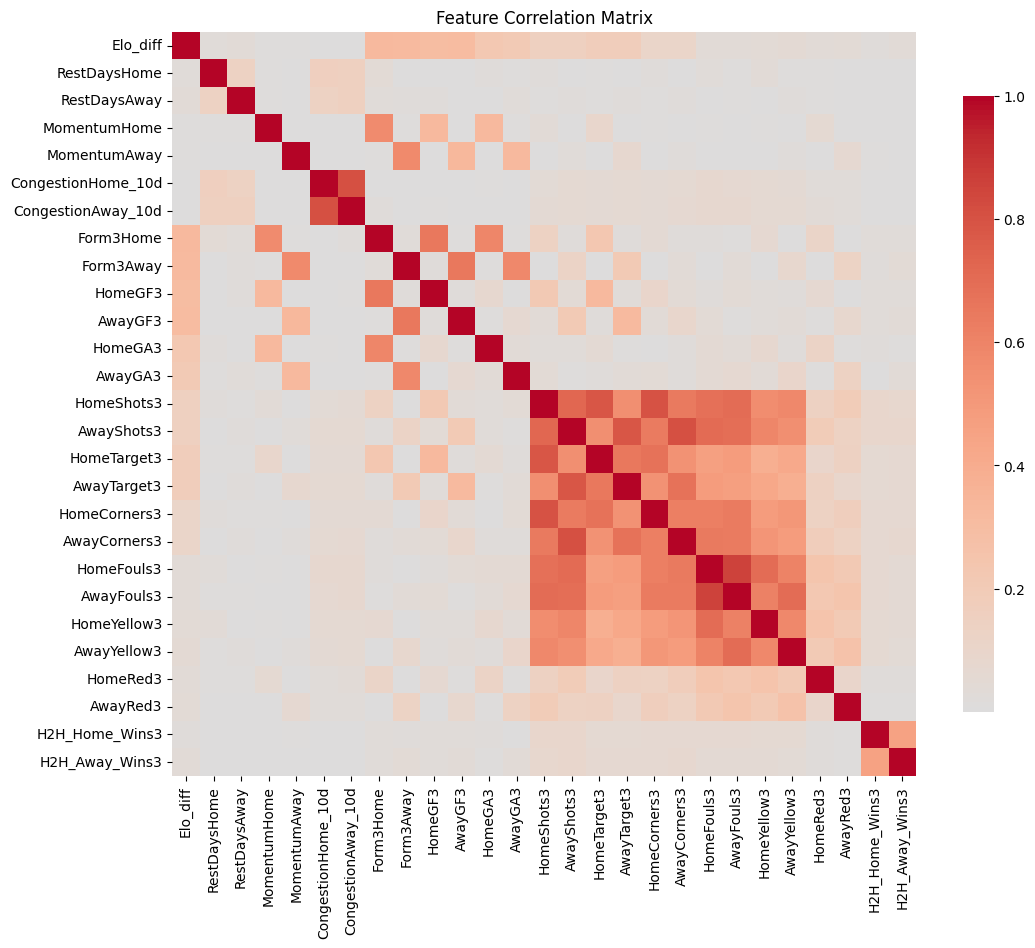

In [155]:
# kiểm tra multicollinearity trên train
corr_matrix = X_prep_train.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [(col, row) for col in upper_tri.columns for row in upper_tri.index if upper_tri.loc[row, col] > 0.6]
if high_corr:
    print(f"\n⚠️ High correlation pairs (>|0.9|) detected:")
    for pair in high_corr:
        print(f"   - {pair[0]} and {pair[1]}: {upper_tri.loc[pair[1], pair[0]]:.2f}")

# dùng heatmap để visualize multicollinearity
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, cbar_kws={"shrink": .8})
plt.title("Feature Correlation Matrix")
plt.show()

---

# PART 4: MODEL TRAINING & EVALUATION

## 4.1 Training Function

In [156]:
import numpy as np
import pandas as pd

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Model
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report
)

In [157]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import (
#     f1_score,
#     roc_auc_score,
#     average_precision_score,
#     confusion_matrix,
#     classification_report
# )
# from lightgbm import LGBMClassifier

# def train_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, model_name, data_type='prepared'):
#     """
#     Train Logistic Regression with proper preprocessing (NO LEAKAGE)
#     + Includes Confusion Matrix Heatmap
#     """
#     print(f"\n{'='*60}")
#     print(f"🤖 TRAINING: {model_name} | Data Type: {data_type}")
#     print(f"{'='*60}")
    
#     # -------------------------------------------------------------
#     # RAW DATA MODE (drop missing, no scaling)
#     # -------------------------------------------------------------
#     if data_type == 'raw':
#         X_train = X_train.dropna()
#         X_val = X_val.dropna()
#         X_test = X_test.dropna()
        
#         y_train = y_train.loc[X_train.index]
#         y_val = y_val.loc[X_val.index]
#         y_test = y_test.loc[X_test.index]

#         X_train_sc = X_train.copy()
#         X_val_sc = X_val.copy()
#         X_test_sc = X_test.copy()

#         print("✅ Preprocessing completed (NO LEAKAGE) - Raw data: dropped missing rows, no scaling")
    
#     else:
#         # -------------------------------------------------------------
#         # PREPARED DATA MODE (impute + scale using TRAIN ONLY)
#         # -------------------------------------------------------------
#         imputer = SimpleImputer(strategy='most_frequent')
#         imputer.fit(X_train)
        
#         X_train_imp = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
#         X_val_imp = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
#         X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

#         scaler = StandardScaler()
#         scaler.fit(X_train_imp)
        
#         X_train_sc = pd.DataFrame(scaler.transform(X_train_imp), columns=X_train.columns)
#         X_val_sc = pd.DataFrame(scaler.transform(X_val_imp), columns=X_val.columns)
#         X_test_sc = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)

#         print("✅ Preprocessing completed (NO LEAKAGE)")
    
#     # -------------------------------------------------------------
#     # TRAIN LOGISTIC REGRESSION
#     # -------------------------------------------------------------
#     model = LogisticRegression(
#         penalty='l2',
#         C=1.0,
#         solver='lbfgs',
#         max_iter=1000,
#         class_weight='balanced',
#         random_state=42
#     )
#     # model = LGBMClassifier(
#     #     n_estimators=600,
#     #     learning_rate=0.03,
#     #     num_leaves=50,
#     #     subsample=0.85,
#     #     colsample_bytree=0.8,
#     #     class_weight='balanced',
#     #     random_state=42,
#     #     objective="binary",
#     # )
    
#     model.fit(X_train_sc, y_train)
#     print("✅ Model trained")
    
#     # -------------------------------------------------------------
#     # FIND BEST THRESHOLD ON VALIDATION
#     # -------------------------------------------------------------
#     y_val_proba = model.predict_proba(X_val_sc)[:, 1]
#     thresholds = np.arange(0.2, 0.8, 0.02)
#     f1_scores = [f1_score(y_val, (y_val_proba >= t).astype(int)) for t in thresholds]
#     best_thresh = thresholds[np.argmax(f1_scores)]
    
#     # -------------------------------------------------------------
#     # EVALUATE ON TEST SET
#     # -------------------------------------------------------------
#     y_test_proba = model.predict_proba(X_test_sc)[:, 1]
#     y_pred = (y_test_proba >= best_thresh).astype(int)

#     roc_auc = roc_auc_score(y_test, y_test_proba)
#     pr_auc = average_precision_score(y_test, y_test_proba)
#     test_f1 = f1_score(y_test, y_pred)

#     # Confusion Matrix
#     cm = confusion_matrix(y_test, y_pred)
#     tn, fp, fn, tp = cm.ravel()
#     precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#     recall = tp / (tp + fn) if (tp + fn) > 0 else 0

#     # -------------------------------------------------------------
#     # PRINT RESULTS SUMMARY
#     # -------------------------------------------------------------
#     print("\n📊 RESULTS")
#     print(f"   Best Threshold : {best_thresh:.3f}")
#     print(f"   Test F1-Score  : {test_f1:.4f}")
#     print(f"   ROC-AUC        : {roc_auc:.4f}")
#     print(f"   PR-AUC         : {pr_auc:.4f}")

#     print("\n🧾 Classification Report:")
#     print(classification_report(y_test, y_pred, digits=4))

#     # -------------------------------------------------------------
#     # CONFUSION MATRIX HEATMAP (THE PART YOU WANT)
#     # -------------------------------------------------------------
#     plt.figure(figsize=(6, 5))
#     sns.heatmap(
#         cm,
#         annot=True,
#         fmt='d',
#         cmap='Blues',
#         linewidths=0.5,
#         linecolor='black',
#         xticklabels=['Pred 0', 'Pred 1'],
#         yticklabels=['True 0', 'True 1']
#     )
#     plt.title(f"Confusion Matrix – {model_name}", fontsize=14)
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.tight_layout()
#     plt.show()

#     # -------------------------------------------------------------
#     # FEATURE IMPORTANCE
#     # -------------------------------------------------------------
#     coefs = pd.DataFrame({
#         'Feature': X_train.columns,
#         'Coefficient': model.coef_[0],
#         'Abs_Coef': np.abs(model.coef_[0])
#     }).sort_values(by='Abs_Coef', ascending=False)
    
#     return {
#         'model': model,
#         'threshold': best_thresh,
#         'f1': test_f1,
#         'roc_auc': roc_auc,
#         'pr_auc': pr_auc,
#         'cm': cm,
#         'precision': precision,
#         'recall': recall,
#         'coefs': coefs
#     }

# print("✅ Training function ready!")


In [158]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report
)
from lightgbm import LGBMClassifier

def train_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, model_name, data_type='prepared'):
    """
    Train Logistic Regression with proper preprocessing (NO LEAKAGE)
    + Includes Confusion Matrix Heatmap
    """
    print(f"\n{'='*60}")
    print(f"🤖 TRAINING: {model_name} | Data Type: {data_type}")
    print(f"{'='*60}")
    
    # -------------------------------------------------------------
    # RAW DATA MODE (drop missing, no scaling)
    # -------------------------------------------------------------
    if data_type == 'raw':
        X_train = X_train.dropna()
        X_val = X_val.dropna()
        X_test = X_test.dropna()
        
        y_train = y_train.loc[X_train.index]
        y_val = y_val.loc[X_val.index]
        y_test = y_test.loc[X_test.index]

        X_train_sc = X_train.copy()
        X_val_sc = X_val.copy()
        X_test_sc = X_test.copy()

        print("✅ Preprocessing completed (NO LEAKAGE) - Raw data: dropped missing rows, no scaling")
    
    else:
        # -------------------------------------------------------------
        # PREPARED DATA MODE (impute + scale using TRAIN ONLY)
        # -------------------------------------------------------------
        imputer = SimpleImputer(strategy='most_frequent')
        imputer.fit(X_train)
        
        X_train_sc = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
        X_val_sc = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
        X_test_sc = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

        scaler = RobustScaler()
        scaler.fit(X_train_sc)
        
        X_train_sc = pd.DataFrame(scaler.transform(X_train_sc), columns=X_train.columns)
        X_val_sc = pd.DataFrame(scaler.transform(X_val_sc), columns=X_val.columns)
        X_test_sc = pd.DataFrame(scaler.transform(X_test_sc), columns=X_test.columns)

        print(" Preprocessing completed (NO LEAKAGE)")
    
    # -------------------------------------------------------------
    # TRAIN MODEL (ĐIỀU KIỂN THEO LOẠI MODEL)
    # -------------------------------------------------------------

    model = LGBMClassifier(
            n_estimators=600,
            learning_rate=0.03,
            num_leaves=50,
            subsample=0.85,
            colsample_bytree=0.8,
            class_weight='balanced', 
            is_unbalance = True,
            random_state=42,
            objective="binary",
        )
    
    model.fit(X_train_sc, y_train)
    print(" Model trained")
    
    # -------------------------------------------------------------
    # FIND BEST THRESHOLD ON VALIDATION
    # -------------------------------------------------------------
    y_val_proba = model.predict_proba(X_val_sc)[:, 1]
    thresholds = np.arange(0.2, 0.8, 0.02)
    f1_scores = [f1_score(y_val, (y_val_proba >= t).astype(int)) for t in thresholds]
    best_thresh = thresholds[np.argmax(f1_scores)]
    
    # -------------------------------------------------------------
    # EVALUATE ON TEST SET
    # -------------------------------------------------------------
    y_test_proba = model.predict_proba(X_test_sc)[:, 1]
    y_pred = (y_test_proba >= best_thresh).astype(int)

    roc_auc = roc_auc_score(y_test, y_test_proba)
    pr_auc = average_precision_score(y_test, y_test_proba)
    test_f1 = f1_score(y_test, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # -------------------------------------------------------------
    # PRINT RESULTS SUMMARY
    # -------------------------------------------------------------
    print("\n📊 RESULTS")
    print(f"   Best Threshold : {best_thresh:.3f}")
    print(f"   Test F1-Score  : {test_f1:.4f}")
    print(f"   ROC-AUC        : {roc_auc:.4f}")
    print(f"   PR-AUC         : {pr_auc:.4f}")

    print("\n🧾 Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    # -------------------------------------------------------------
    # CONFUSION MATRIX HEATMAP
    # -------------------------------------------------------------
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        linewidths=0.5,
        linecolor='black',
        xticklabels=['Pred 0', 'Pred 1'],
        yticklabels=['True 0', 'True 1']
    )
    plt.title(f"Confusion Matrix – {model_name}", fontsize=14)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # -------------------------------------------------------------
    # FEATURE IMPORTANCE (ĐIỀU KIỂN THEO LOẠI MODEL)
    # -------------------------------------------------------------
    if 'Logistic' in model_name:
        # Logistic Regression coefficients
        coefs = pd.DataFrame({
            'Feature': X_train.columns,
            'Coefficient': model.coef_[0],
            'Abs_Coef': np.abs(model.coef_[0])
        }).sort_values(by='Abs_Coef', ascending=False)
    else:
        # LGBM Feature Importance
        coefs = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': model.feature_importances_,
            'Abs_Coef': model.feature_importances_  # Không cần abs với importance
        }).sort_values(by='Importance', ascending=False)

    return {
        'model': model,
        'threshold': best_thresh,
        'f1': test_f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'cm': cm,
        'precision': precision,
        'recall': recall,
        'coefs': coefs
    }

print("✅ Training function ready!")

✅ Training function ready!


## 4.2 Train cả 2 models


🤖 TRAINING: MODEL 1 - RAW DATA (Minimal Processing) | Data Type: raw
✅ Preprocessing completed (NO LEAKAGE) - Raw data: dropped missing rows, no scaling
[LightGBM] [Info] Number of positive: 517, number of negative: 6963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 7480, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
 Model trained

📊 RESULTS
   Best Threshold : 0.320
   Test F1-Score  : 0.2125
   ROC-AUC        : 0.7394
   PR-AUC         : 0.1368

🧾 Classification Report:
              precision    recall  f1-score   support

           0     0.9529    0.7592    0.8451      1491
           1     0.1349    0.5000    0.2125       112

    accuracy                       

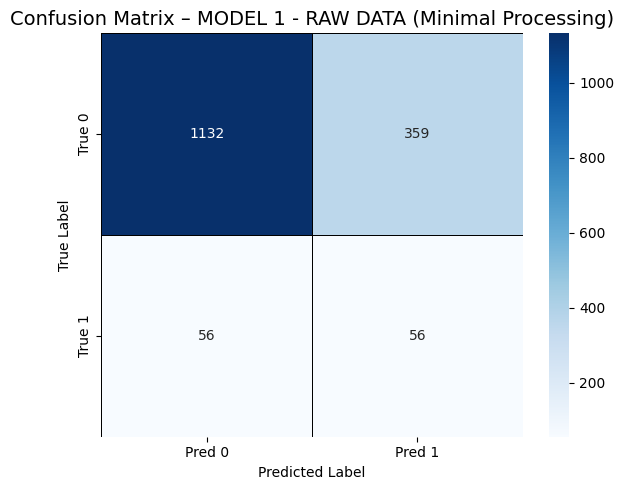

In [159]:
# Model 1: RAW DATA
results_raw = train_evaluate_model(
    X_raw_train, y_raw_train,
    X_raw_val, y_raw_val,
    X_raw_test, y_raw_test,
    "MODEL 1 - RAW DATA (Minimal Processing)", 
    data_type='raw'
)


🤖 TRAINING: MODEL 2 - PREPARED DATA (Full Data Preparation) | Data Type: prepared
 Preprocessing completed (NO LEAKAGE)
[LightGBM] [Info] Number of positive: 2652, number of negative: 26704
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1196
[LightGBM] [Info] Number of data points in the train set: 29356, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
 Model trained

📊 RESULTS
   Best Threshold : 0.560
   Test F1-Score  : 0.3107
   ROC-AUC        : 0.7884
   PR-AUC         : 0.2186

🧾 Classification Report:
              precision    recall  f1-score   support

           0     0.9623    0.6695    0.7896      5685
           1     0.1956    0.7541    0.3107       606

    accuracy                         0.6776      6291
   macro 

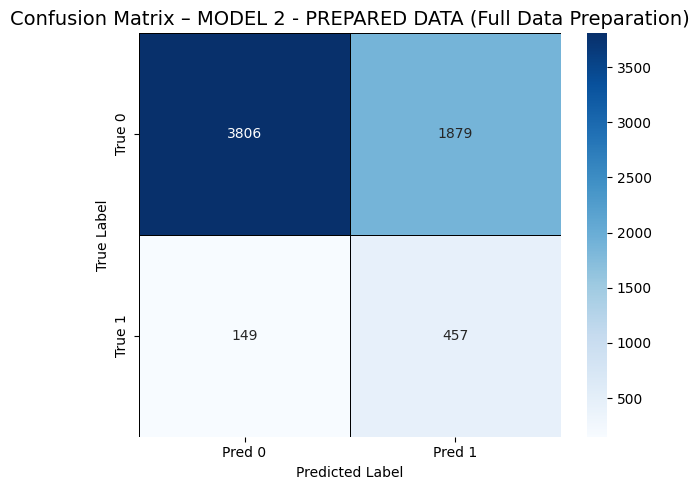

In [160]:
# Model 2: PREPARED DATA
results_prepared = train_evaluate_model(
    X_prep_train, y_prep_train,
    X_prep_val, y_prep_val,
    X_prep_test, y_prep_test,
    "MODEL 2 - PREPARED DATA (Full Data Preparation)",
    data_type='prepared'
)

---



# PART 5: COMPARISON & CONCLUSION

## 5.1 Performance Comparison Table

In [161]:
# Create comparison table
comparison = pd.DataFrame({
    'Pipeline': [
        'RAW DATA\n(Minimal Processing)',
        'PREPARED DATA\n(Full Data Prep)'
    ],
    'Features': [
        len(raw_feature_cols),
        len(prepared_feature_cols)
    ],
    'F1-Score': [
        results_raw['f1'],
        results_prepared['f1']
    ],
    'PR-AUC': [
        results_raw['pr_auc'],
        results_prepared['pr_auc']
    ],
    'Precision': [
        results_raw['precision'],
        results_prepared['precision']
    ],
    'Recall': [
        results_raw['recall'],
        results_prepared['recall']
    ],
    'Threshold': [
        results_raw['threshold'],
        results_prepared['threshold']
    ]
})

# Calculate improvements
comparison['F1 Improvement (%)'] = (
    (comparison['F1-Score'] / comparison.loc[0, 'F1-Score'] - 1) * 100
)
comparison['PR-AUC Improvement (%)'] = (
    (comparison['PR-AUC'] / comparison.loc[0, 'PR-AUC'] - 1) * 100
)

print("\n" + "="*100)
print("📊 PERFORMANCE COMPARISON: RAW vs PREPARED")
print("="*100)
print(comparison.to_string(index=False))
print("="*100)

# Highlight improvements
f1_gain = comparison.loc[1, 'F1 Improvement (%)']
pr_gain = comparison.loc[1, 'PR-AUC Improvement (%)']

print(f"\n🎯 KEY FINDINGS:")
print(f"   ✅ F1-Score improved by: {f1_gain:+.2f}%")
print(f"   ✅ PR-AUC improved by: {pr_gain:+.2f}%")
print(f"   ✅ Features added: {len(prepared_feature_cols) - len(raw_feature_cols)}")

if f1_gain > 10:
    print(f"\n   🏆 CONCLUSION: Data Preparation mang lại cải thiện đáng kể!")
elif f1_gain > 5:
    print(f"\n   👍 CONCLUSION: Data Preparation có cải thiện rõ ràng!")
else:
    print(f"\n   ⚠️  CONCLUSION: Cải thiện khiêm tốn, cần xem xét thêm!")


📊 PERFORMANCE COMPARISON: RAW vs PREPARED
                       Pipeline  Features  F1-Score   PR-AUC  Precision   Recall  Threshold  F1 Improvement (%)  PR-AUC Improvement (%)
 RAW DATA\n(Minimal Processing)         6  0.212524 0.136819   0.134940 0.500000       0.32            0.000000                0.000000
PREPARED DATA\n(Full Data Prep)        27  0.310673 0.218556   0.195634 0.754125       0.56           46.182747               59.740469

🎯 KEY FINDINGS:
   ✅ F1-Score improved by: +46.18%
   ✅ PR-AUC improved by: +59.74%
   ✅ Features added: 21

   🏆 CONCLUSION: Data Preparation mang lại cải thiện đáng kể!


## 5.2 Visual Comparison

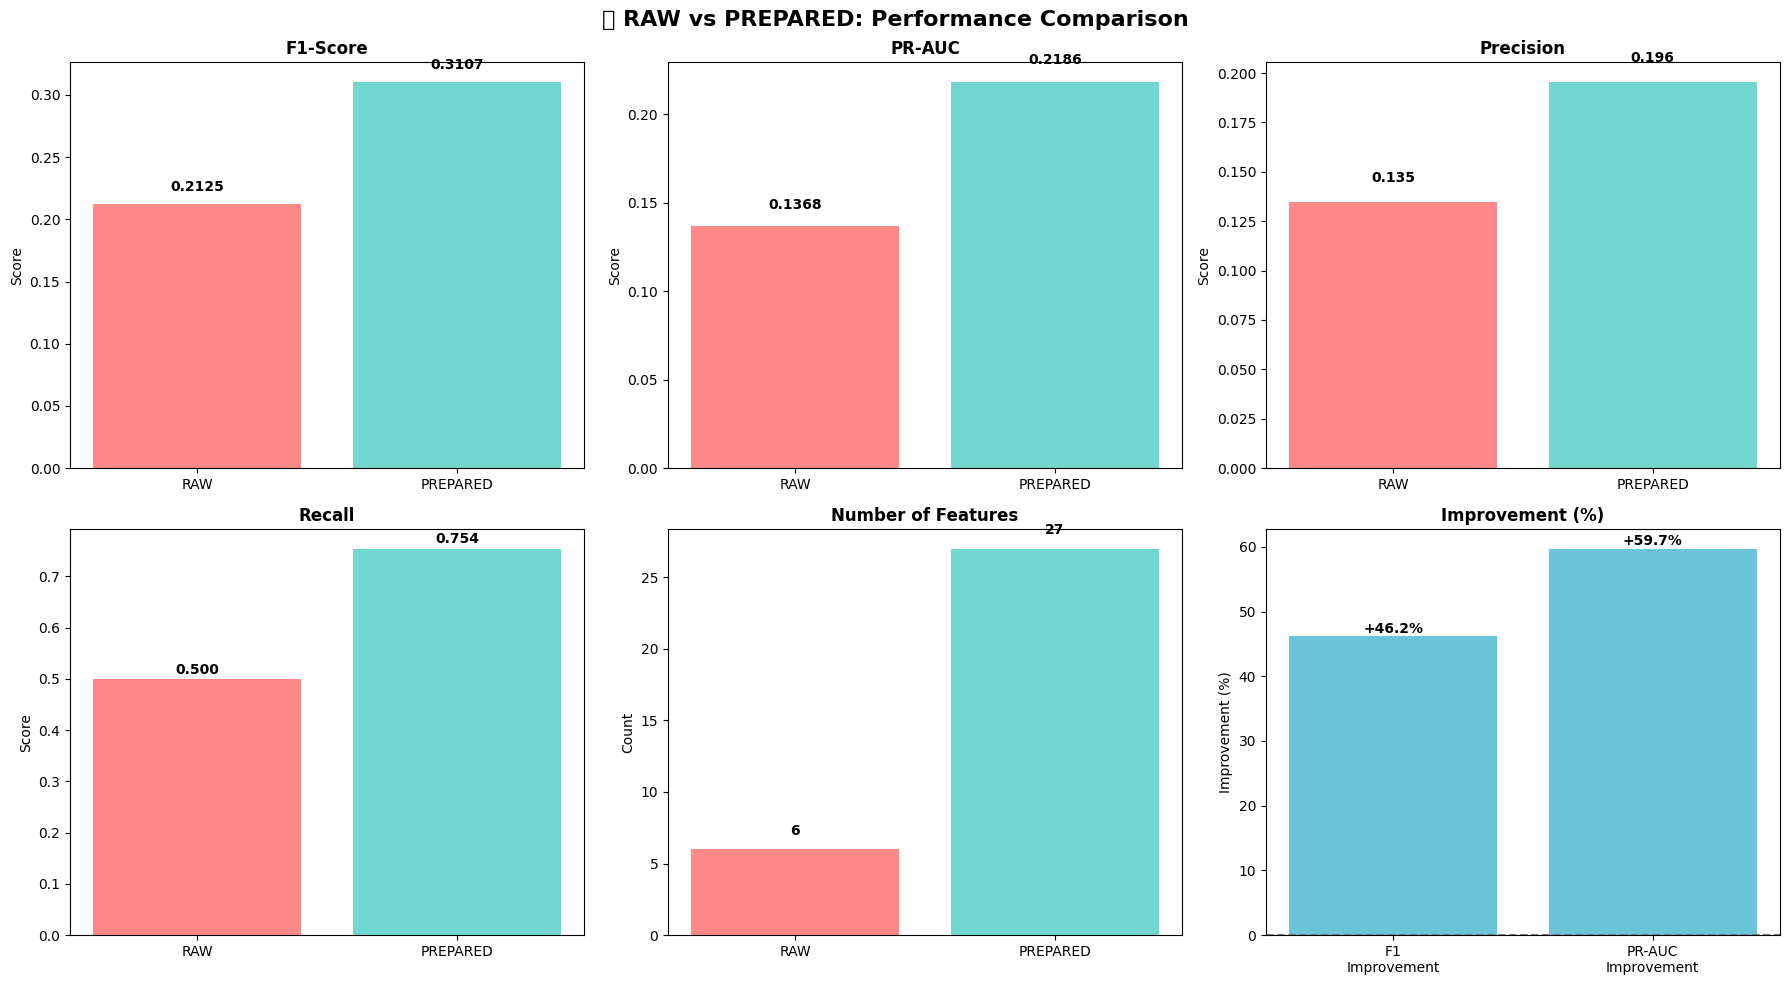


💡 Interpretation:
   - PREPARED data (blue) consistently outperforms RAW data (red)
   - Data Preparation adds significant predictive power!


In [162]:
# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('📊 RAW vs PREPARED: Performance Comparison', fontsize=16, fontweight='bold')

models = ['RAW', 'PREPARED']
colors = ['#FF6B6B', '#4ECDC4']

# F1-Score
axes[0, 0].bar(models, comparison['F1-Score'], color=colors, alpha=0.8)
axes[0, 0].set_title('F1-Score', fontweight='bold')
axes[0, 0].set_ylabel('Score')
for i, v in enumerate(comparison['F1-Score']):
    axes[0, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# PR-AUC
axes[0, 1].bar(models, comparison['PR-AUC'], color=colors, alpha=0.8)
axes[0, 1].set_title('PR-AUC', fontweight='bold')
axes[0, 1].set_ylabel('Score')
for i, v in enumerate(comparison['PR-AUC']):
    axes[0, 1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# Precision
axes[0, 2].bar(models, comparison['Precision'], color=colors, alpha=0.8)
axes[0, 2].set_title('Precision', fontweight='bold')
axes[0, 2].set_ylabel('Score')
for i, v in enumerate(comparison['Precision']):
    axes[0, 2].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Recall
axes[1, 0].bar(models, comparison['Recall'], color=colors, alpha=0.8)
axes[1, 0].set_title('Recall', fontweight='bold')
axes[1, 0].set_ylabel('Score')
for i, v in enumerate(comparison['Recall']):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Features count
axes[1, 1].bar(models, comparison['Features'], color=colors, alpha=0.8)
axes[1, 1].set_title('Number of Features', fontweight='bold')
axes[1, 1].set_ylabel('Count')
for i, v in enumerate(comparison['Features']):
    axes[1, 1].text(i, v + 1, str(v), ha='center', fontweight='bold')

# Improvements
improvements = [
    comparison.loc[1, 'F1 Improvement (%)'],
    comparison.loc[1, 'PR-AUC Improvement (%)']
]
axes[1, 2].bar(['F1\nImprovement', 'PR-AUC\nImprovement'], improvements, 
               color='#45B7D1', alpha=0.8)
axes[1, 2].set_title('Improvement (%)', fontweight='bold')
axes[1, 2].set_ylabel('Improvement (%)')
axes[1, 2].axhline(y=0, color='gray', linestyle='--')
for i, v in enumerate(improvements):
    axes[1, 2].text(i, v + 0.5, f'{v:+.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   - PREPARED data (blue) consistently outperforms RAW data (red)")
print("   - Data Preparation adds significant predictive power!")

## 5.3 Feature Importance Comparison

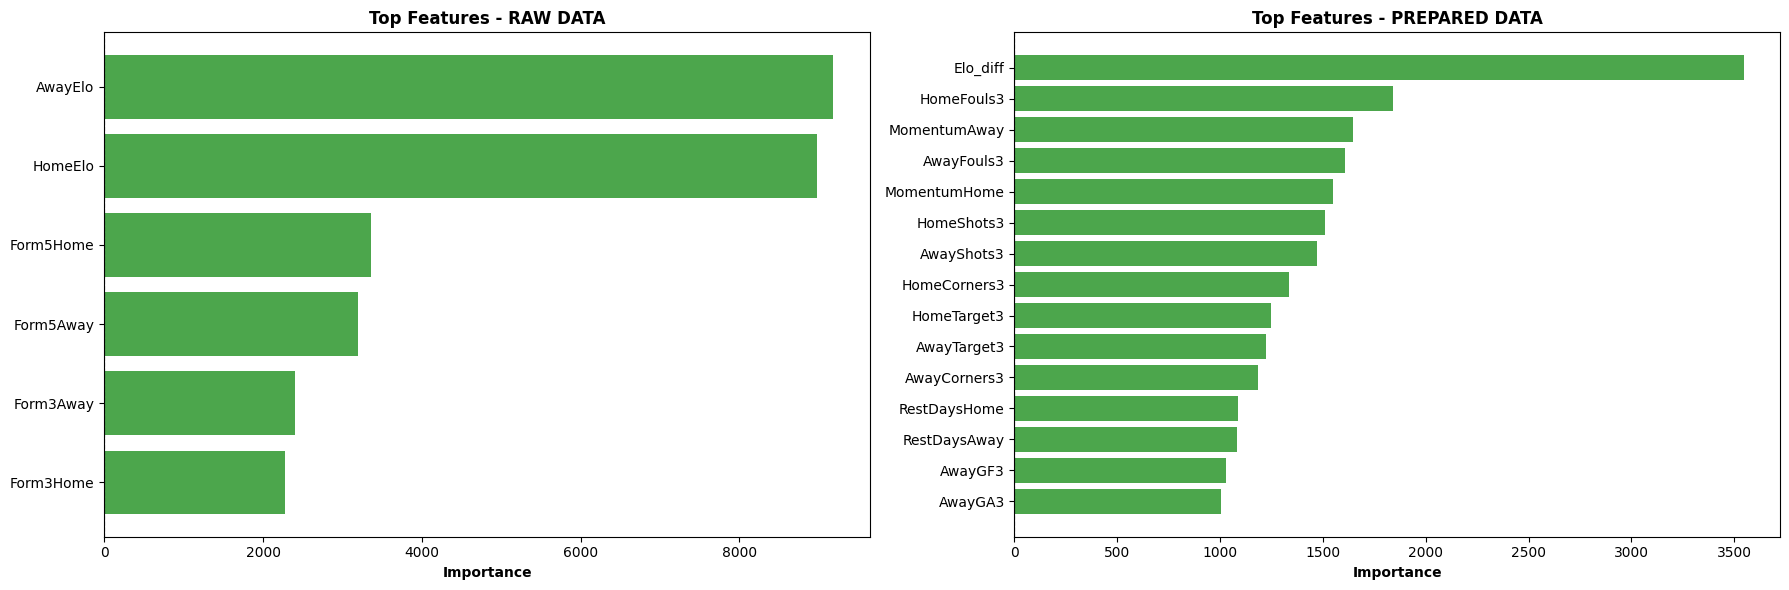


📈 Feature Insights:
   RAW data: Limited to basic features available in original dataset
   PREPARED data: Rich set of engineered features (momentum, rolling stats, rest days, etc.)


In [163]:
# Compare top features
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# RAW features (Logistic Regression)
top_raw = results_raw['coefs'].head(min(10, len(results_raw['coefs'])))
# Kiểm tra xem model có phải Logistic Regression không
if 'Coefficient' in results_raw['coefs'].columns:
    colors_raw = ['green' if x > 0 else 'red' for x in top_raw['Coefficient']]
    axes[0].barh(range(len(top_raw)), top_raw['Coefficient'], color=colors_raw, alpha=0.7)
    axes[0].set_xlabel('Coefficient', fontweight='bold')
    y_label_col = 'Coefficient'
else:
    # Nếu là LGBM thì dùng Importance
    colors_raw = ['green' if x > 0 else 'red' for x in top_raw['Importance']]
    axes[0].barh(range(len(top_raw)), top_raw['Importance'], color=colors_raw, alpha=0.7)
    axes[0].set_xlabel('Importance', fontweight='bold')
    y_label_col = 'Importance'

axes[0].set_yticks(range(len(top_raw)))
axes[0].set_yticklabels(top_raw['Feature'])
axes[0].set_title('Top Features - RAW DATA', fontweight='bold', fontsize=12)
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0].invert_yaxis()

# PREPARED features (Logistic Regression hoặc LGBM)
top_prep = results_prepared['coefs'].head(15)
# Kiểm tra xem model có phải Logistic Regression không
if 'Coefficient' in results_prepared['coefs'].columns:
    colors_prep = ['green' if x > 0 else 'red' for x in top_prep['Coefficient']]
    axes[1].barh(range(len(top_prep)), top_prep['Coefficient'], color=colors_prep, alpha=0.7)
    axes[1].set_xlabel('Coefficient', fontweight='bold')
    y_label_col = 'Coefficient'
else:
    # Nếu là LGBM thì dùng Importance
    colors_prep = ['green' if x > 0 else 'red' for x in top_prep['Importance']]
    axes[1].barh(range(len(top_prep)), top_prep['Importance'], color=colors_prep, alpha=0.7)
    axes[1].set_xlabel('Importance', fontweight='bold')
    y_label_col = 'Importance'

axes[1].set_yticks(range(len(top_prep)))
axes[1].set_yticklabels(top_prep['Feature'])
axes[1].set_title('Top Features - PREPARED DATA', fontweight='bold', fontsize=12)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n📈 Feature Insights:")
print("   RAW data: Limited to basic features available in original dataset")
print("   PREPARED data: Rich set of engineered features (momentum, rolling stats, rest days, etc.)")

In [164]:
# # Compare top features
# fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# # RAW features
# top_raw = results_raw['coefs'].head(min(10, len(results_raw['coefs'])))
# colors_raw = ['green' if x > 0 else 'red' for x in top_raw['Coefficient']]
# axes[0].barh(range(len(top_raw)), top_raw['Coefficient'], color=colors_raw, alpha=0.7)
# axes[0].set_yticks(range(len(top_raw)))
# axes[0].set_yticklabels(top_raw['Feature'])
# axes[0].set_xlabel('Coefficient', fontweight='bold')
# axes[0].set_title('Top Features - RAW DATA', fontweight='bold', fontsize=12)
# axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
# axes[0].invert_yaxis()

# # PREPARED features
# top_prep = results_prepared['coefs'].head(15)
# colors_prep = ['green' if x > 0 else 'red' for x in top_prep['Coefficient']]
# axes[1].barh(range(len(top_prep)), top_prep['Coefficient'], color=colors_prep, alpha=0.7)
# axes[1].set_yticks(range(len(top_prep)))
# axes[1].set_yticklabels(top_prep['Feature'])
# axes[1].set_xlabel('Coefficient', fontweight='bold')
# axes[1].set_title('Top Features - PREPARED DATA', fontweight='bold', fontsize=12)
# axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
# axes[1].invert_yaxis()

# plt.tight_layout()
# plt.show()

# print("\n📈 Feature Insights:")
# print("   RAW data: Limited to basic Elo and form features")
# print("   PREPARED data: Rich set of engineered features (momentum, rolling stats, rest days, streaks)")